*Antonio Coín Castro*     

# Linear - p free

In [19]:
# -- Libraries

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import arviz as az
import numpy as np
import bayesian_model
import simulation
import mle
from sklearn.svm import SVR
import pandas as pd
from IPython.display import display
import plot_utils
import logging
import skfda
from _fpca_basis import FPCABasis
from itertools import product
from skfda.preprocessing.dim_reduction.variable_selection import (
    RecursiveMaximaHunting as RMH,
    MinimumRedundancyMaximumRelevance as mRMR,
)
import os
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.ml.regression import KNeighborsRegressor
from skfda.ml.regression import LinearRegression as FLinearRegression
from skfda.representation.basis import FDataBasis, Fourier, BSpline
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.validation import (
    SmoothingParameterSearch,
    LinearSmootherGeneralizedCVScorer,
    akaike_information_criterion
)
from skfda.preprocessing.smoothing.kernel_smoothers import (
    NadarayaWatsonSmoother as NW
)
import warnings
from _fpls import FPLS, APLS, FPLSBasis
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import sys
import pickle
import scipy
from multiprocessing import Pool
import utils
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [11]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## New functions


**Importante**

- Función "get_params" editada en ThetaSpace.
- Hay valores de $\tau$ fuera de rango porque si, por ejemplo, $\tau=(0.3, 0.6, 1.2)$ pero $p=2$, el tercer valor es ignorado, y pasa como valor "válido" de $\theta$.
- Los valores de la columna 'Features' en el resultado de point_predict están mal (siempre reporta el p máximo).

In [12]:
# -- Model hyperparameters

p_hat = 3
g = 5
eta = 0.1

# Prior on p

prior_p = {
    1: 0.1,
    2: 0.4,
    3: 0.5,
}


TRANSFORM_TAU = False
FIT_SK = False

In [13]:
# -- Names and labels

# Names of parameters
theta_names = ["p", "β", "τ", "α0", "σ2"]
if TRANSFORM_TAU:
    theta_names_ttr = ["p", "β", "logit τ", "α0", "log σ"]
else:
    theta_names_ttr = ["p", "β", "τ", "α0", "log σ"]
theta_names_aux = ["α0 and log σ"]

# Grouped labels
theta_labels_grouped = [r"$p$", r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = [r"$p$"]
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

# Names of results columns
results_columns = ["Estimator", "Features", "MSE", "RMSE", r"$R^2$"]

In [14]:
# -- Functions

def round_p(p):
    rounded_p = int(np.rint(p))
    return np.clip(rounded_p, 1, p_hat)

# -- Log-posterior model

def log_prior(theta_tr):
    n, N = X.shape
    grid = theta_space.grid
    p = theta_tr[0]
    
    if p < 0.5 or p > p_hat + 0.5:
        return -np.inf
    
    p = round_p(p)
    theta_tr_fixed = theta_tr[1:]
    theta = theta_space.backward(theta_tr_fixed)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta, p)
    log_sigma = theta_space.get_sigma2(theta_tr_fixed)

    if not TRANSFORM_TAU:
        if (tau < theta_space.tau_lb).any() or (tau > theta_space.tau_ub).any():
            return -np.inf

    # Transform variables
    b = beta - b0[:p]

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 + np.log(prior_p[p])
                 - p*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma2))

    return log_prior


def log_likelihood(theta_tr, Y):
    """Global parameters (for efficient parallelization): 
        X, theta_space, return_ll"""
    n, N = X.shape
    grid = theta_space.grid

    p = round_p(theta_tr[0])
    theta_tr_fixed = theta_tr[1:]
    theta = theta_space.backward(theta_tr_fixed)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta, p)
    log_sigma = theta_space.get_sigma2(theta_tr_fixed)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    ll = (-n*log_sigma
          - np.linalg.norm(Y - alpha0 - X_tau@beta)**2/(2*sigma2))

    if return_ll:
        # Add constant term so that it is the genuine log-probability
        ll_pointwise = (-log_sigma - 0.5*np.log(2*np.pi)
                        - (Y - alpha0 - X_tau@beta)**2/(2*sigma2))
        return ll, ll_pointwise
    else:
        return ll


def log_posterior(theta_tr, Y):
    """Global parameters (for efficient parallelization): 
        X, rng, return_pp, return_ll, theta_space"""
    
    # Compute log-prior
    lp = log_prior(theta_tr)

    if not np.isfinite(lp):
        if return_pp and return_ll:
            return -np.inf, np.full_like(Y, -np.inf), np.full_like(Y, -np.inf)
        elif return_pp:
            return -np.inf, np.full_like(Y, -np.inf)
        elif return_ll:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    # Compute log-likelihood (and possibly pointwise log-likelihood)
    if return_ll:
        ll, ll_pointwise = log_likelihood(theta_tr, Y)
    else:
        ll = log_likelihood(theta_tr, Y)

    # Compute log-posterior
    lpos = lp + ll

    # Compute posterior predictive samples
    if return_pp:
        theta = theta_space.backward(theta_tr[1:])
        pp = generate_response(
            X, 
            np.concatenate(([theta_tr[0]], theta)), 
            rng=rng)

    # Return information
    if return_pp and return_ll:
        return lpos, pp, ll_pointwise
    elif return_pp:
        return lpos, pp
    elif return_ll:
        return lpos, ll_pointwise
    else:
        return lpos
    
# -- Trace

def emcee_to_idata(
    sampler,
    theta_space,
    burn,
    thin,
    pp_names=[],
    is_blob_ll=False
):
    names = theta_space.names
    names_ttr = theta_space.names_ttr
    p = theta_space.p
    n_pp = len(pp_names)
    blob_names = []
    blob_groups = []
    dims = {f"{names_ttr[1]}": ["vector"],
            f"{names_ttr[2]}": ["vector"],
            "y_obs": ["observation"]}

    if n_pp > 0:
        new_vars = {}
        for name in pp_names:
            new_vars[name] = ["prediction"]

        blob_names = pp_names
        blob_groups = n_pp*["posterior_predictive"]
        dims = {**dims, **new_vars}
    if is_blob_ll:
        blob_names += ["y_obs"]
        blob_groups += ["log_likelihood"]

    if len(blob_names) == 0:  # No blobs
        blob_names = None
        blob_groups = None

    idata = az.from_emcee(
        sampler,
        var_names=names_ttr,
        slices=[0, slice(1, p + 1), slice(p + 1, 2*p + 1), -2, -1],
        arg_names=["y_obs"],
        blob_names=blob_names,
        blob_groups=blob_groups,
        dims=dims
    )

    # Burn-in and thinning
    idata = idata.sel(draw=slice(burn, None, thin))

    idata.posterior[names[2]] = \
        theta_space.tau_ttr.backward(idata.posterior[names_ttr[2]])
    idata.posterior[names[-1]] = \
        theta_space.sigma2_ttr.backward(idata.posterior[names_ttr[-1]])

    return idata

def get_trace_emcee(sampler, theta_space, burn, thin, flat=False):
    trace = np.copy(sampler.get_chain(discard=burn, thin=thin))
    trace[:, :, theta_space.tau_idx] = theta_space.tau_ttr.backward(
        trace[:, :, theta_space.tau_idx + 1])
    trace[:, :, theta_space.sigma2_idx] = theta_space.sigma2_ttr.backward(
        trace[:, :, theta_space.sigma2_idx])

    if flat:
        trace = trace.reshape(-1, trace.shape[-1])  # All chains combined

    return trace

# -- Response and posterior predictive

def generate_pp(
        idata, X, var_names, thin=1, rng=None,
        kind='regression', progress='notebook'):
    from tqdm.notebook import tqdm as tqdm_notebook
    if rng is None:
        rng = np.random.default_rng()

    n = X.shape[0]
    posterior_trace = idata.posterior
    n_chain = len(posterior_trace["chain"])
    n_draw = len(posterior_trace["draw"])
    range_draws = range(0, n_draw, thin)
    pp_y = np.zeros((n_chain, len(range_draws), n))

    if kind == 'classification':
        pp_p = np.zeros((n_chain, len(range_draws), n))

    if progress is True:
        chain_range = tqdm(range(n_chain), "Posterior predictive samples")
    elif progress == 'notebook':
        chain_range = tqdm_notebook(
            range(n_chain), "Posterior predictive samples")
    else:
        chain_range = range(n_chain)

    for i in chain_range:
        for j, jj in enumerate(range_draws):
            theta_ds = posterior_trace[var_names].isel(
                chain=i, draw=jj).data_vars.values()
            theta = np.concatenate([param.values.ravel()
                                    for param in theta_ds])

            if kind == 'classification':
                Y_star, p_star = generate_response_logistic(
                    X, theta, return_p=True, rng=rng)
                pp_p[i, j, :] = p_star
            else:
                Y_star = generate_response(X, theta, rng=rng)

            pp_y[i, j, :] = Y_star

    if kind == 'classification':
        return pp_p, pp_y.astype(int)
    else:
        return pp_y
    
def generate_response(X, theta, noise=True, rng=None):
    """Generate a response when the parameter vector 'theta' is (β, τ, α0, σ2)."""
    n, N = X.shape
    grid = np.linspace(1./N, 1., N)
    p = round_p(theta[0])
    theta_fixed = theta[1:]
    
    beta = theta_fixed[:p_hat][:p]
    tau = theta_fixed[p_hat:2*p_hat][:p]
    alpha0 = theta_fixed[-2]
    sigma = np.sqrt(theta_fixed[-1])

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    Y = alpha0 + X_tau@beta

    if noise:
        if rng is None:
            rng = np.random.default_rng()
        Y += sigma*rng.standard_normal(size=n)

    return Y

# -- Prediction

def point_predict(X, idata, names, pe='mean', kind='regression'):
    theta = utils.point_estimate(idata, pe, names)

    if kind == 'regression':
        Y_hat = generate_response(X, theta, noise=False)
    else:
        Y_hat = generate_response_logistic(X, theta, prob=False)

    return Y_hat


# -- Variable selection

def bayesian_var_sel(idata, theta_space, names,
                     X, Y, X_test, Y_test, folds,
                     prefix, point_est='mode',
                     verbose=False):
    grid = theta_space.grid
    p_hat = theta_space.p
    theta_hat = utils.point_estimate(idata, point_est, names)
    p = round_p(theta_hat[0])
    tau_hat = theta_space.get_tau(theta_hat[1:])[:p]
    idx_hat = np.abs(grid - tau_hat[:, np.newaxis]).argmin(1)

    regressors_var_sel = []
    alphas = np.logspace(-4, 4, 20)
    params_reg = {"reg__alpha": alphas}
    params_svm = {"reg__C": alphas,
                  "reg__gamma": ['auto', 'scale']}

    # Emcee+Lasso
    regressors_var_sel.append((f"{prefix}_{point_est}+sk_lasso",
                              Pipeline([
                                  ("var_sel", VariableSelection(grid, idx_hat)),
                                  ("data_matrix", DataMatrix()),
                                  ("reg", Lasso())]),
                              params_reg
                               ))

    # Emcee+Ridge
    regressors_var_sel.append((f"{prefix}_{point_est}+sk_ridge",
                              Pipeline([
                                  ("var_sel", VariableSelection(grid, idx_hat)),
                                  ("data_matrix", DataMatrix()),
                                  ("reg", Ridge())]),
                              params_reg
                               ))

    # Emcee+SVM RBF
    regressors_var_sel.append((f"{prefix}_{point_est}+sk_svm_rbf",
                              Pipeline([
                                  ("var_sel", VariableSelection(grid, idx_hat)),
                                  ("data_matrix", DataMatrix()),
                                  ("reg", SVR(kernel='rbf'))]),
                              params_svm
                               ))

    df_metrics_var_sel, _ = cv_sk(regressors_var_sel, folds,
                                  X, Y, X_test, Y_test, verbose)

    return df_metrics_var_sel

## Example dataset

In [15]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Aemet"

INITIAL_SMOOTHING = 'NW'  # None, 'NW' or 'Basis'
N_BASIS = 16
STANDARDIZE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

kernel_fn = simulation.fractional_brownian_kernel
beta_coef = simulation.cholaquidis_scenario3

basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning:One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan -0.001 -0.001 -0.001
 -0.001 -0.001 -0.    -0.    -0.001 -0.001 -0.001 -0.002 -0.003 -0.006
 -0.012 -0.023 -0.043 -0.065 -0.081 -0.09  -0.094 -0.096 -0.097 -0.098
 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098
 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098 -0.098]


Smoother: NadarayaWatsonSmoother
Smoothing parameter: 0.013


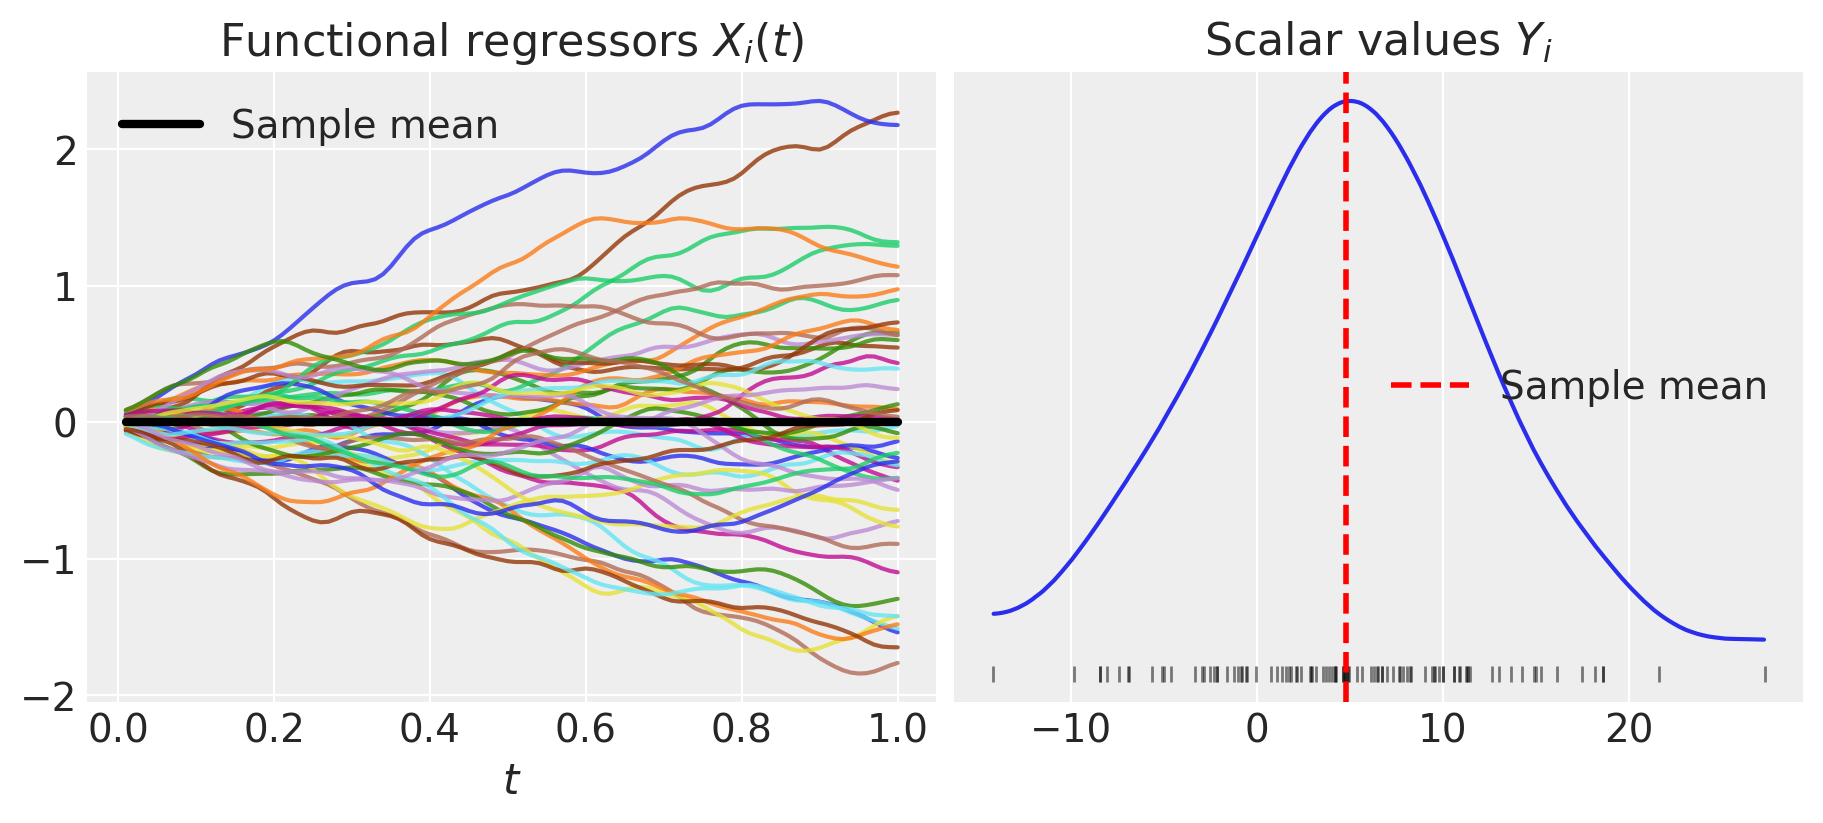

In [21]:
# -- Dataset generation

if SYNTHETIC_DATA:
    n_train, n_test = 100, 50
    N = 100
    grid = np.linspace(1./N, 1., N)

    beta_true = np.array([-5., 10.])
    tau_true = np.array([0.1, 0.8])
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        x, y = simulation.generate_gp_l2_dataset(
            grid, kernel_fn,
            n_train + n_test, beta_coef, alpha0_true,
            sigma2_true, rng=rng
        )
    elif MODEL_GEN == "RKHS":
        x, y = simulation.generate_gp_rkhs_dataset(
            grid, kernel_fn,
            n_train + n_test, beta_true, tau_true,
            alpha0_true, sigma2_true, rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        y = np.sqrt(y[:, 1])  # Sqrt-Fat
    elif REAL_DATA == "Aemet":
        data = skfda.datasets.fetch_aemet()['data']
        data_matrix = data.data_matrix
        temperature = data_matrix[:, :, 0]
        x = FDataGrid(temperature, data.grid_points)
        # Log-Sum of log-precipitation for each station
        y = np.log(np.exp(data_matrix[:, :, 1]).sum(axis=1))
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.8, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = np.linspace(1./N, 1., N)  # TODO: use (normalized) real grid
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    best_smoother = SmoothingParameterSearch(
        smoother,
        smoothing_params,
        scoring=LinearSmootherGeneralizedCVScorer(
            akaike_information_criterion),
        n_jobs=-1,
    )

    with utils.IgnoreWarnings():
        best_smoother.fit(X_fd)

    X_fd = best_smoother.transform(X_fd)
    X_test_fd = best_smoother.transform(X_test_fd)
    print(f"Smoother: {best_smoother.best_estimator_.__class__.__name__}")
    print(
        f"Smoothing parameter: {best_smoother.best_params_['smoothing_parameter']:.3f}")

if STANDARDIZE_PREDICTORS:
    X_sd = np.sqrt(X_fd.var())
else:
    X_sd = 1.0

if STANDARDIZE_RESPONSE:
    Y_m = Y.mean()
    Y_sd = Y.std()
else:
    Y_m = 0.0
    Y_sd = 1.0

# Standardize data
X_m = X_fd.mean(axis=0)
X_fd = (X_fd - X_m)/X_sd
X = X_fd.data_matrix.reshape(-1, N)
X_test_fd = (X_test_fd - X_m)/X_sd
X_test = X_test_fd.data_matrix.reshape(-1, N)
Y = (Y - Y_m)/Y_sd
Y_test = (Y_test - Y_m)/Y_sd

plot_utils.plot_dataset_regression(
    X, Y, n_samples=n_train if not SYNTHETIC_DATA else n_train//2)

## Common model hyperparameters

In [25]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_hat, 
    grid, 
    include_p=True,
    names=theta_names, 
    labels=theta_labels, 
    tau_ttr=tau_ttr
)

# Statistics for posterior predictive checks
statistics = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)]

# Point estimates for posterior distribution
point_estimates = ["mode", "mean", "median"]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

## Sklearn model comparison

In [26]:
# -- Custom CV and transformers

def cv_sk(regressors, folds, X, Y, X_test, Y_test, verbose=False):
    df_metrics_sk = pd.DataFrame(columns=results_columns)

    for i, (name, pipe, params) in enumerate(regressors):
        if verbose:
            print(f"Fitting {name}...")
        reg_cv = GridSearchCV(pipe, params, scoring="neg_mean_squared_error",
                              n_jobs=N_CORES, cv=folds)

        with utils.IgnoreWarnings():
            reg_cv.fit(X, Y)

        Y_hat_sk = reg_cv.predict(X_test)
        metrics_sk = utils.regression_metrics(Y_test, Y_hat_sk)

        if name == "sk_fknn":
            n_features = f"K={reg_cv.best_params_['reg__n_neighbors']}"
        elif "svm" in name:
            n_features = reg_cv.best_estimator_["reg"].n_features_in_
        elif "pls1" in name:
            n_features = reg_cv.best_estimator_["reg"].n_components
        else:
            if isinstance(reg_cv.best_estimator_["reg"].coef_[0], FDataBasis):
                coef = reg_cv.best_estimator_["reg"].coef_[0].coefficients[0]
            else:
                coef = reg_cv.best_estimator_["reg"].coef_

            n_features = sum(~np.isclose(coef, 0))

        df_metrics_sk.loc[i] = [
            name,
            n_features,
            metrics_sk["mse"],
            metrics_sk["rmse"],
            metrics_sk["r2"]]

        df_metrics_sk.sort_values(results_columns[-2], inplace=True)

    return df_metrics_sk, reg_cv





class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y=None):
        N = X.shape[1]
        self.idx_ = np.linspace(0, N - 1, self.p).astype(int)
        return self

    def transform(self, X, y=None):
        return X[:, self.idx_]


class DataMatrix(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.N = len(X.grid_points[0])
        return self

    def transform(self, X, y=None):
        return X.data_matrix.reshape(-1, self.N)


class Basis(BaseEstimator, TransformerMixin):

    def __init__(self, basis=Fourier()):
        self.basis = basis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.to_basis(self.basis)


class VariableSelection(BaseEstimator, TransformerMixin):

    def __init__(self, grid=None, idx=None):
        self.grid = grid
        self.idx = idx
        self.idx.sort()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return FDataGrid(X.data_matrix[:, self.idx], self.grid[self.idx])


class PLSRegressionWrapper(PLSRegression):

    def transform(self, X, y=None):
        check_is_fitted(self)

        return super().transform(X)

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

    def predict(self, X, copy=True):
        check_is_fitted(self)

        if self.coef_.shape[1] == 1:  # if n_targets == 1
            return super().predict(X, copy)[:, 0]
        else:
            return super().predict(X, copy)

In [27]:
# -- Select family of regressors

regressors = []

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

params_reg = {"reg__alpha": alphas}
params_svm = {"reg__C": alphas,
              "reg__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_knn = {"reg__n_neighbors": n_neighbors,
              "reg__weights": ['uniform', 'distance']}
params_mrmr = {"var_sel__method": ["MID", "MIQ"],
               "var_sel__n_features_to_select": n_components}


"""
MULTIVARIATE MODELS
"""

# Lasso
regressors.append(("sk_lasso",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("reg", Lasso())]),
                   params_reg
                   ))

# PLS1 regression
regressors.append(("sk_pls1",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("reg", PLSRegressionWrapper())]),
                   params_pls
                   ))

"""
VARIABLE SELECTION + MULTIVARIATE MODELS
"""

# Manual+Ridge
regressors.append(("manual_sel+sk_ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("reg", Ridge())]),
                   {**params_reg, **params_select}
                   ))

# FPCA+Ridge
regressors.append(("fpca+sk_ridge",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("reg", Ridge())]),
                   {**params_dim_red, **params_reg}
                   ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# FPLS (fixed basis)+Ridge
regressors.append(("fpls_basis+sk_ridge",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("reg", Ridge())]),
                   {**params_basis, **params_dim_red, **params_reg}
                   ))

"""

# PCA+Ridge
regressors.append(("pca+sk_ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("reg", Ridge())]),
                   {**params_dim_red, **params_reg}
                   ))

# PLS+Ridge
regressors.append(("pls+sk_ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("reg", Ridge())]),
                   {**params_dim_red, **params_reg}
                   ))

# RMH+Ridge
regressors.append(("rmh+sk_ridge",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("reg", Ridge())]),
                   params_reg
                   ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# mRMR+Ridge
regressors.append(("mRMR+sk_ridge",
                   Pipeline([
                       ("var_sel", mRMR()),
                       ("reg", Ridge())]),
                   {**params_mrmr, **params_reg}
                   ))
"""

# Manual+SVM RBF
regressors.append(("manual_sel+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_select, **params_svm}
                   ))

# FPCA+SVM RBF
regressors.append(("fpca+sk_svm_rbf",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_dim_red, **params_svm}
                   ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# FPLS (fixed basis)+SMV RBF
regressors.append(("fpls_basis+sk_svm_rbf",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_basis, **params_dim_red, **params_svm}
                   ))
"""

# PCA+SVM RBF
regressors.append(("pca+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_dim_red, **params_svm}
                   ))

# PLS+SMV RBF
regressors.append(("pls+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_dim_red, **params_svm}
                   ))

# RMH+SVM RBF
regressors.append(("rmh+sk_svm_rbf",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("reg", SVR(kernel='rbf'))]),
                   params_svm
                   ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# mRMR+SVM RBF
regressors.append(("mRMR+sk_svm_rbf",
                   Pipeline([
                       ("var_sel", mRMR()),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_mrmr, **params_svm}
                   ))
"""

"""
FUNCTIONAL MODELS
"""

regressors.append(("sk_apls",
                   Pipeline([
                       ("reg", APLS())]),
                   params_pls
                   ))

# NOTE: while not strictly necessary, the test data undergoes the
# same basis expansion process as the training data. This is more
# computationally efficient and seems to improve the performance.

# Fixed basis + Functional Linear Regression
regressors.append(("sk_flin_basis",
                   Pipeline([
                       ("basis", Basis()),
                       ("reg", FLinearRegression())]),
                   params_basis
                   ))

"""
TARDA BASTANTE (cálculo de Gram matrix costoso en la base)

# FPCA basis + Functional Linear Regression
regressors.append(("sk_flin_khl",
                   Pipeline([
                       ("basis", FPCABasis()),
                       ("reg", FLinearRegression())]),
                   params_basis_fpca
                   ))
"""

"""
TARDA BASTANTE (cálculo de Gram matrix costoso en la base)

# FPLS basis + Functional Linear Regression
regressors.append(("sk_flin_fpls",
                   Pipeline([
                       ("basis", Basis()),
                       ("reg", FLinearRegression())]),
                   params_basis_fpls
                   ))
"""

# Fixed basis + FPLS1 regression
regressors.append(("sk_fpls1_basis",
                   Pipeline([
                       ("basis", Basis()),
                       ("reg", FPLS())]),
                   {**params_basis, **params_pls}
                   ))

# KNeighbors Functional Regression
regressors.append(("sk_fknn",
                   Pipeline([
                       ("reg", KNeighborsRegressor())]),
                   params_knn
                   ))

In [13]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = cv_sk(regressors, folds, X_fd, Y,
                                  X_test_fd, Y_test, verbose=True)
    display(df_metrics_sk.style.hide_index())

Fitting sk_lasso...
Fitting sk_pls1...
Fitting manual_sel+sk_ridge...
Fitting fpca+sk_ridge...
Fitting pca+sk_ridge...
Fitting pls+sk_ridge...
Fitting rmh+sk_ridge...
Fitting manual_sel+sk_svm_rbf...
Fitting fpca+sk_svm_rbf...
Fitting pca+sk_svm_rbf...
Fitting pls+sk_svm_rbf...
Fitting rmh+sk_svm_rbf...
Fitting sk_apls...
Fitting sk_flin_basis...
Fitting sk_fpls1_basis...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/

Fitting sk_fknn...


## Maximum Likelihood Estimator

In [28]:
# -- Negative log-likelihood definition in transformed parameter space

def neg_ll(theta_tr, X, Y, theta_space):
    """Transformed parameter vector 'theta_tr' is (β, τ, α0, log σ)."""

    n, N = X.shape
    grid = theta_space.grid

    theta = theta_space.backward(theta_tr)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta)
    log_sigma = theta_space.get_sigma2(theta_tr)
    
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    return -(-n*log_sigma
             - np.linalg.norm(Y - alpha0 - X_tau@beta)**2/(2*sigma2))

In [29]:
# -- MLE estimation functions

def optimizer_global(random_state, args):
    theta_init, X, Y, theta_space, method, bounds = args
    return scipy.optimize.basinhopping(
        neg_ll,
        x0=theta_init,
        seed=random_state,
        minimizer_kwargs={"args": (X, Y, theta_space),
                          "method": method,
                          "bounds": bounds}
    ).x


def compute_mle(
        theta_space, X, Y,
        method='Powell',
        strategy='global',
        rng=None):
    if rng is None:
        rng = np.random.default_rng()

    p = theta_space.p

    theta_init = theta_space.forward(
        np.array([0.0]*p + [0.5]*p + [Y.mean()] + [1.0]))

    if TRANSFORM_TAU:
        bounds = None
    else:
        bounds = ([(None, None)]*p
                  + [(theta_space.tau_lb, theta_space.tau_ub)]*p
                  + [(None, None)]
                  + [(None, None)])

    with utils.IgnoreWarnings():
        if strategy == 'local':
            mle_theta = scipy.optimize.minimize(
                neg_ll,
                x0=theta_init,
                bounds=bounds,
                method=method,
                args=(X, Y, theta_space)
            ).x
            bic = mle_utils.compute_bic(theta_space, neg_ll, mle_theta, X, Y)
        elif strategy == 'global':
            mles = np.zeros((N_CORES, theta_space.ndim))

            with Pool(N_CORES) as pool:
                print(f"-- Computing MLE with {N_CORES} independent runs --")
                random_states = [rng.integers(2**32) for i in range(N_CORES)]
                args_optim = [theta_init, X, Y, theta_space, method, bounds]
                mles = pool.starmap(
                    optimizer_global, product(random_states, [args_optim]))
                bics = mle_utils.compute_bic(
                    theta_space, neg_ll, mles, X, Y)
                mle_theta = mles[np.argmin(bics)]
                bic = bics[np.argmin(bics)]
        else:
            raise ValueError(
                "Parameter 'strategy' must be one of {'local', 'global'}.")

    return mle_theta, bic

In [30]:
# -- MLE computation

method_mle = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
strategy_mle = 'global'


mle_theta_tr, bic = compute_mle(
    theta_space, X, Y, method_mle,
    strategy_mle, rng)
mle_theta = theta_space.backward(mle_theta_tr)

Y_hat_mle = utils.generate_response(X_test, mle_theta, noise=False)
df_metrics_mle = pd.DataFrame(columns=results_columns)
metrics_mle = utils.regression_metrics(Y_test, Y_hat_mle)
df_metrics_mle.loc[0] = [
    "mle",
    p_hat,
    metrics_mle["mse"],
    metrics_mle["rmse"],
    metrics_mle["r2"]
]

print(f"\nBIC: {bic:.3f}")
print("MLE:")
display(pd.DataFrame(zip(theta_space.labels[1:], mle_theta),
                     columns=["", "MLE"]).style.hide_index())
print("Regression metrics:")
df_metrics_mle.style.hide_index()

AttributeError: 'ThetaSpace' object has no attribute 'p'

## The Ensemble Sampler and the *emcee* library

In [179]:
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [180]:
def run_emcee(n_walkers, n_iter_initial, n_iter, moves,
              thin, thin_pp, return_pp, return_ll):
    # -- Run sampler

    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

    logging.disable(sys.maxsize)  # Disable logger

    # Analyze autocorrelation and set burn-in and thinning values
    autocorr = sampler.get_autocorr_time(quiet=True)
    max_autocorr = np.max(autocorr)
    if (np.isfinite(autocorr)).all():
        burn = int(3*max_autocorr)
    else:
        print("Some autocorrelation value is not finite")
        burn = 500

    logging.disable(logging.NOTSET)  # Re-enable logger

    # Get InferenceData object
    idata_emcee = emcee_to_idata(
        sampler, theta_space, burn, thin,
        ["y_star"] if return_pp else [], return_ll)

    print("\n-- Summary statistics --")
    display(utils.summary(idata_emcee, var_names=theta_names,
                          kind="stats", labeller=theta_labeller))

    # -- Compute metrics using several point estimates

    df_metrics_emcee = pd.DataFrame(columns=results_columns)

    # Posterior mean estimate
    pp_test = generate_pp(
        idata_emcee, X_test, theta_names, thin_pp, rng=rng)

    print("Computing metrics...", end="\r")

    Y_hat_pp = pp_test.mean(axis=(0, 1))
    metrics_pp = utils.regression_metrics(Y_test, Y_hat_pp)
    df_metrics_emcee.loc[0] = [
        "emcee_posterior_mean",
        p_hat,
        metrics_pp["mse"],
        metrics_pp["rmse"],
        metrics_pp["r2"]
    ]

    # Point estimates
    for i, pe in enumerate(point_estimates):
        Y_hat_pe = point_predict(
            X_test, idata_emcee,
            theta_names, pe)
        metrics_pe = utils.regression_metrics(Y_test, Y_hat_pe)
        df_metrics_emcee.loc[i + 1] = [
            "emcee_" + pe,
            p_hat,
            metrics_pe["mse"],
            metrics_pe["rmse"],
            metrics_pe["r2"]
        ]

    # Bayesian variable selection
    for pe in point_estimates:
        df_metrics_var_sel = bayesian_var_sel(
            idata_emcee, theta_space, theta_names, X_fd,
            Y, X_test_fd, Y_test, folds, prefix="emcee",
            point_est=pe)

        df_metrics_emcee = df_metrics_emcee.append(df_metrics_var_sel)

    if FIT_SK:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)
    df_metrics_emcee = df_metrics_emcee.append(df_metrics_mle)
    df_metrics_emcee.sort_values(results_columns[-2], inplace=True)

    print("-- Regression metrics --")
    display(df_metrics_emcee.style.hide_index())

    return sampler, idata_emcee, df_metrics_emcee

In [181]:
# -- Sampler parameters

n_walkers = 64
n_iter_initial = 100
n_iter = 1000
return_pp = True
return_ll = False
frac_random = 0.3

sd_beta_init = 1.0
sd_tau_init = 0.2
mean_alpha0_init = Y.mean()
sd_alpha0_init = 1.0
param_sigma2_init = 2.0  # shape parameter in inv_gamma distribution
sd_sigma2_init = 1.0

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True

In [182]:
# -- Run sampler

# Start every walker in a (random) neighbourhood around the MLE
p0_fixed = utils.weighted_initial_guess_around_value(
    theta_space, mle_theta_tr, sd_beta_init, sd_tau_init,
    mean_alpha0_init, sd_alpha0_init, param_sigma2_init,
    sd_sigma2_init, n_walkers=n_walkers, rng=rng,
    frac_random=frac_random)
initial_p = rng.integers(1, p_hat, n_walkers, endpoint=True)
p0 = np.vstack((initial_p.T, p0_fixed.T)).T
b0 = mle_theta_tr[theta_space.beta_idx]

if FAST_RUN:
    sampler, idata_emcee, df_metrics_emcee_full = run_emcee(
        n_walkers, n_iter_initial, n_iter, moves,
        thin, thin_pp, return_pp, return_ll)
else:
    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/100 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean acceptance fraction: 14.117%

-- Summary statistics --


mean      sd   hdi_3%  hdi_97%    mode  median
p           2.262   0.430    1.511    2.860   2.540   2.356
β[0]        9.725   2.026    9.938   10.335  10.121  10.138
β[1]       -3.983   1.036   -4.820   -2.688  -4.631  -4.533
β[2]       -0.986  84.687 -147.889  115.331  -1.186  -1.716
τ[0]        0.776   0.113    0.795    0.805   0.800   0.799
τ[1]        0.120   0.141    0.067    0.133   0.096   0.101
τ[2]        2.345  78.884  -99.933  142.247   0.477   0.086
$\alpha_0$  5.207   0.417    5.030    5.469   5.219   5.239
$\sigma^2$  5.870  25.018    0.483    1.159   0.555   0.725

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

-- Regression metrics --


### Analysis

In [1]:
# -- Sampler statistics and trace (with burn-in and thinning)

logging.disable(sys.maxsize)  # Disable logger

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
if (np.isfinite(autocorr)).all():
    burn = int(3*max_autocorr)
else:
    print("Some autocorrelation value is not finite")
    burn = 500

# Get trace of samples
trace_flat = get_trace_emcee(sampler, theta_space, burn, thin, flat=True)

# Get InferenceData object
idata_emcee = emcee_to_idata(
    sampler, theta_space, burn, thin,
    ["y_star"] if return_pp else [], return_ll)

# Update and show autocorrelation
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)

logging.disable(logging.NOTSET)  # Re-enable logger

pd.DataFrame(
    zip(theta_labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

NameError: name 'logging' is not defined

In [19]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean       sd    hdi_3%  hdi_97%    mode  median
p            2.366    0.583     1.501    3.388   1.606   2.385
β[0]         8.555    5.085    -8.277   10.361  10.114  10.113
β[1]        -3.714    2.288    -4.876    3.848  -4.629  -4.535
β[2]       -51.638  625.353 -1386.780  670.524 -12.323  -1.073
τ[0]         0.747    0.167     0.259    0.805   0.802   0.800
τ[1]         0.153    0.174     0.065    0.690   0.098   0.101
τ[2]         2.613   34.538   -50.213   64.233   0.477   0.111
$\alpha_0$   5.246    0.433     4.050    5.543   5.247   5.242
$\sigma^2$  10.184   30.263     0.332   87.119   0.862   0.729

Combined density and trace plot:


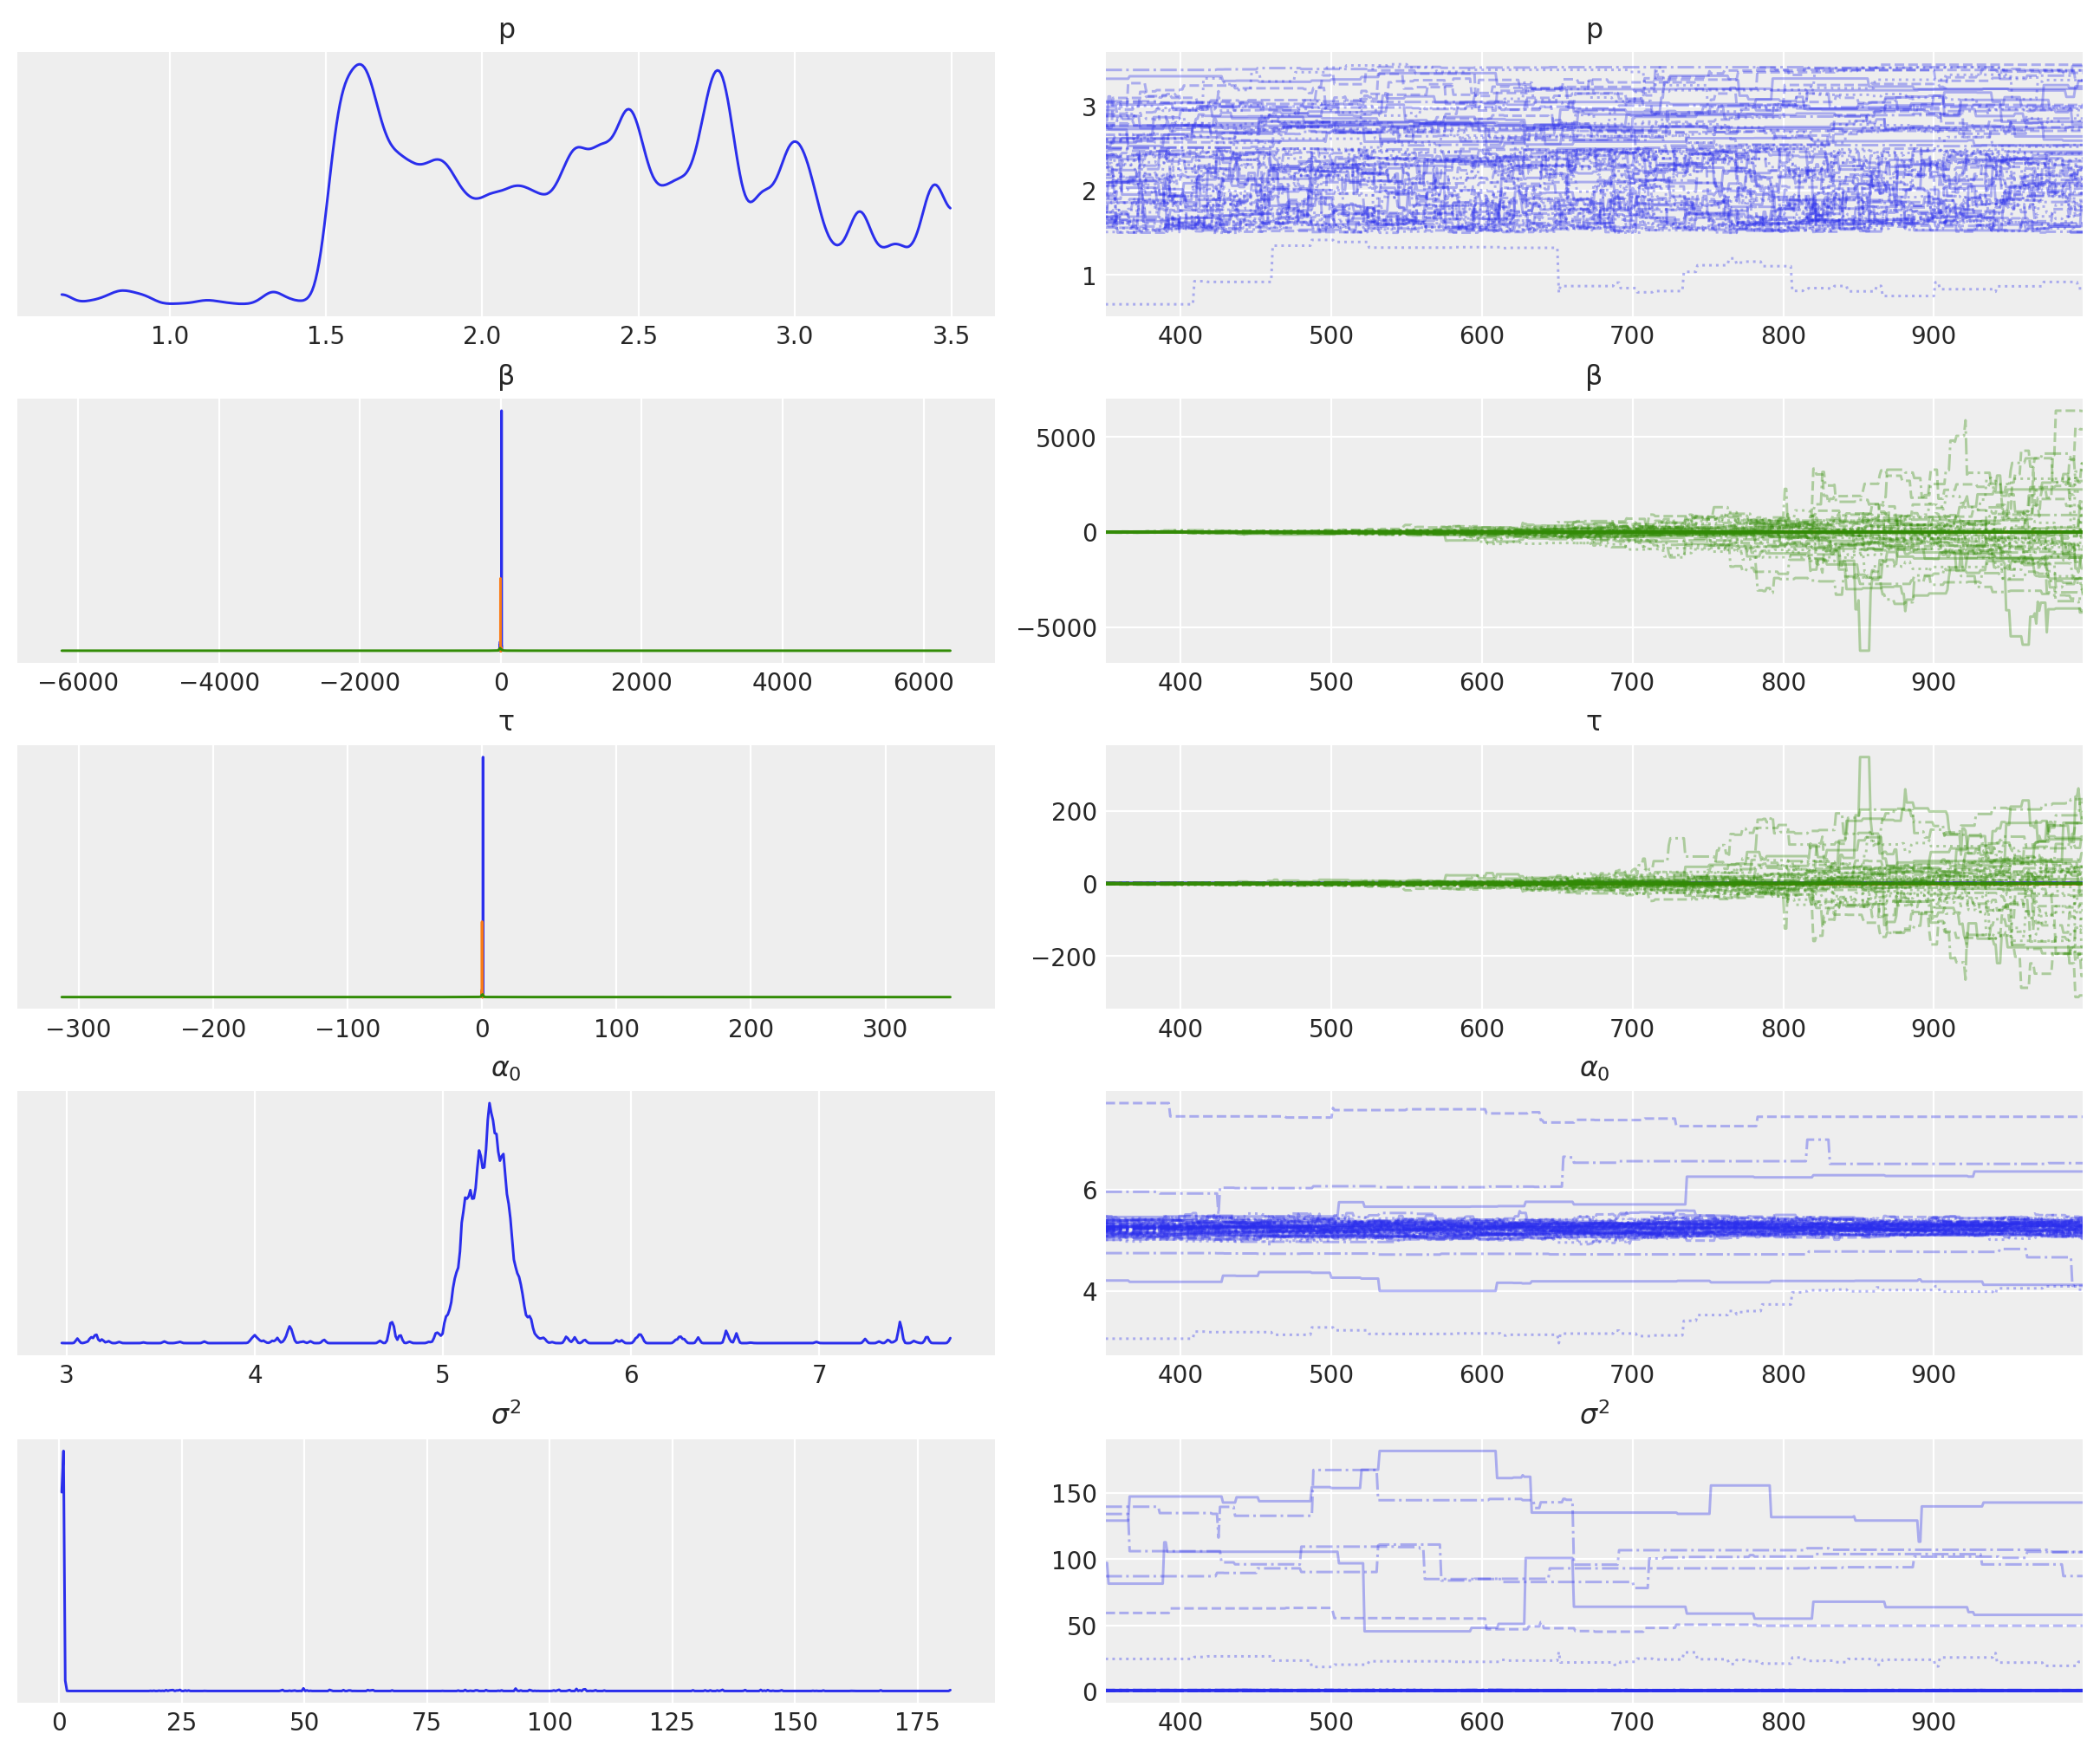

In [20]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
              combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


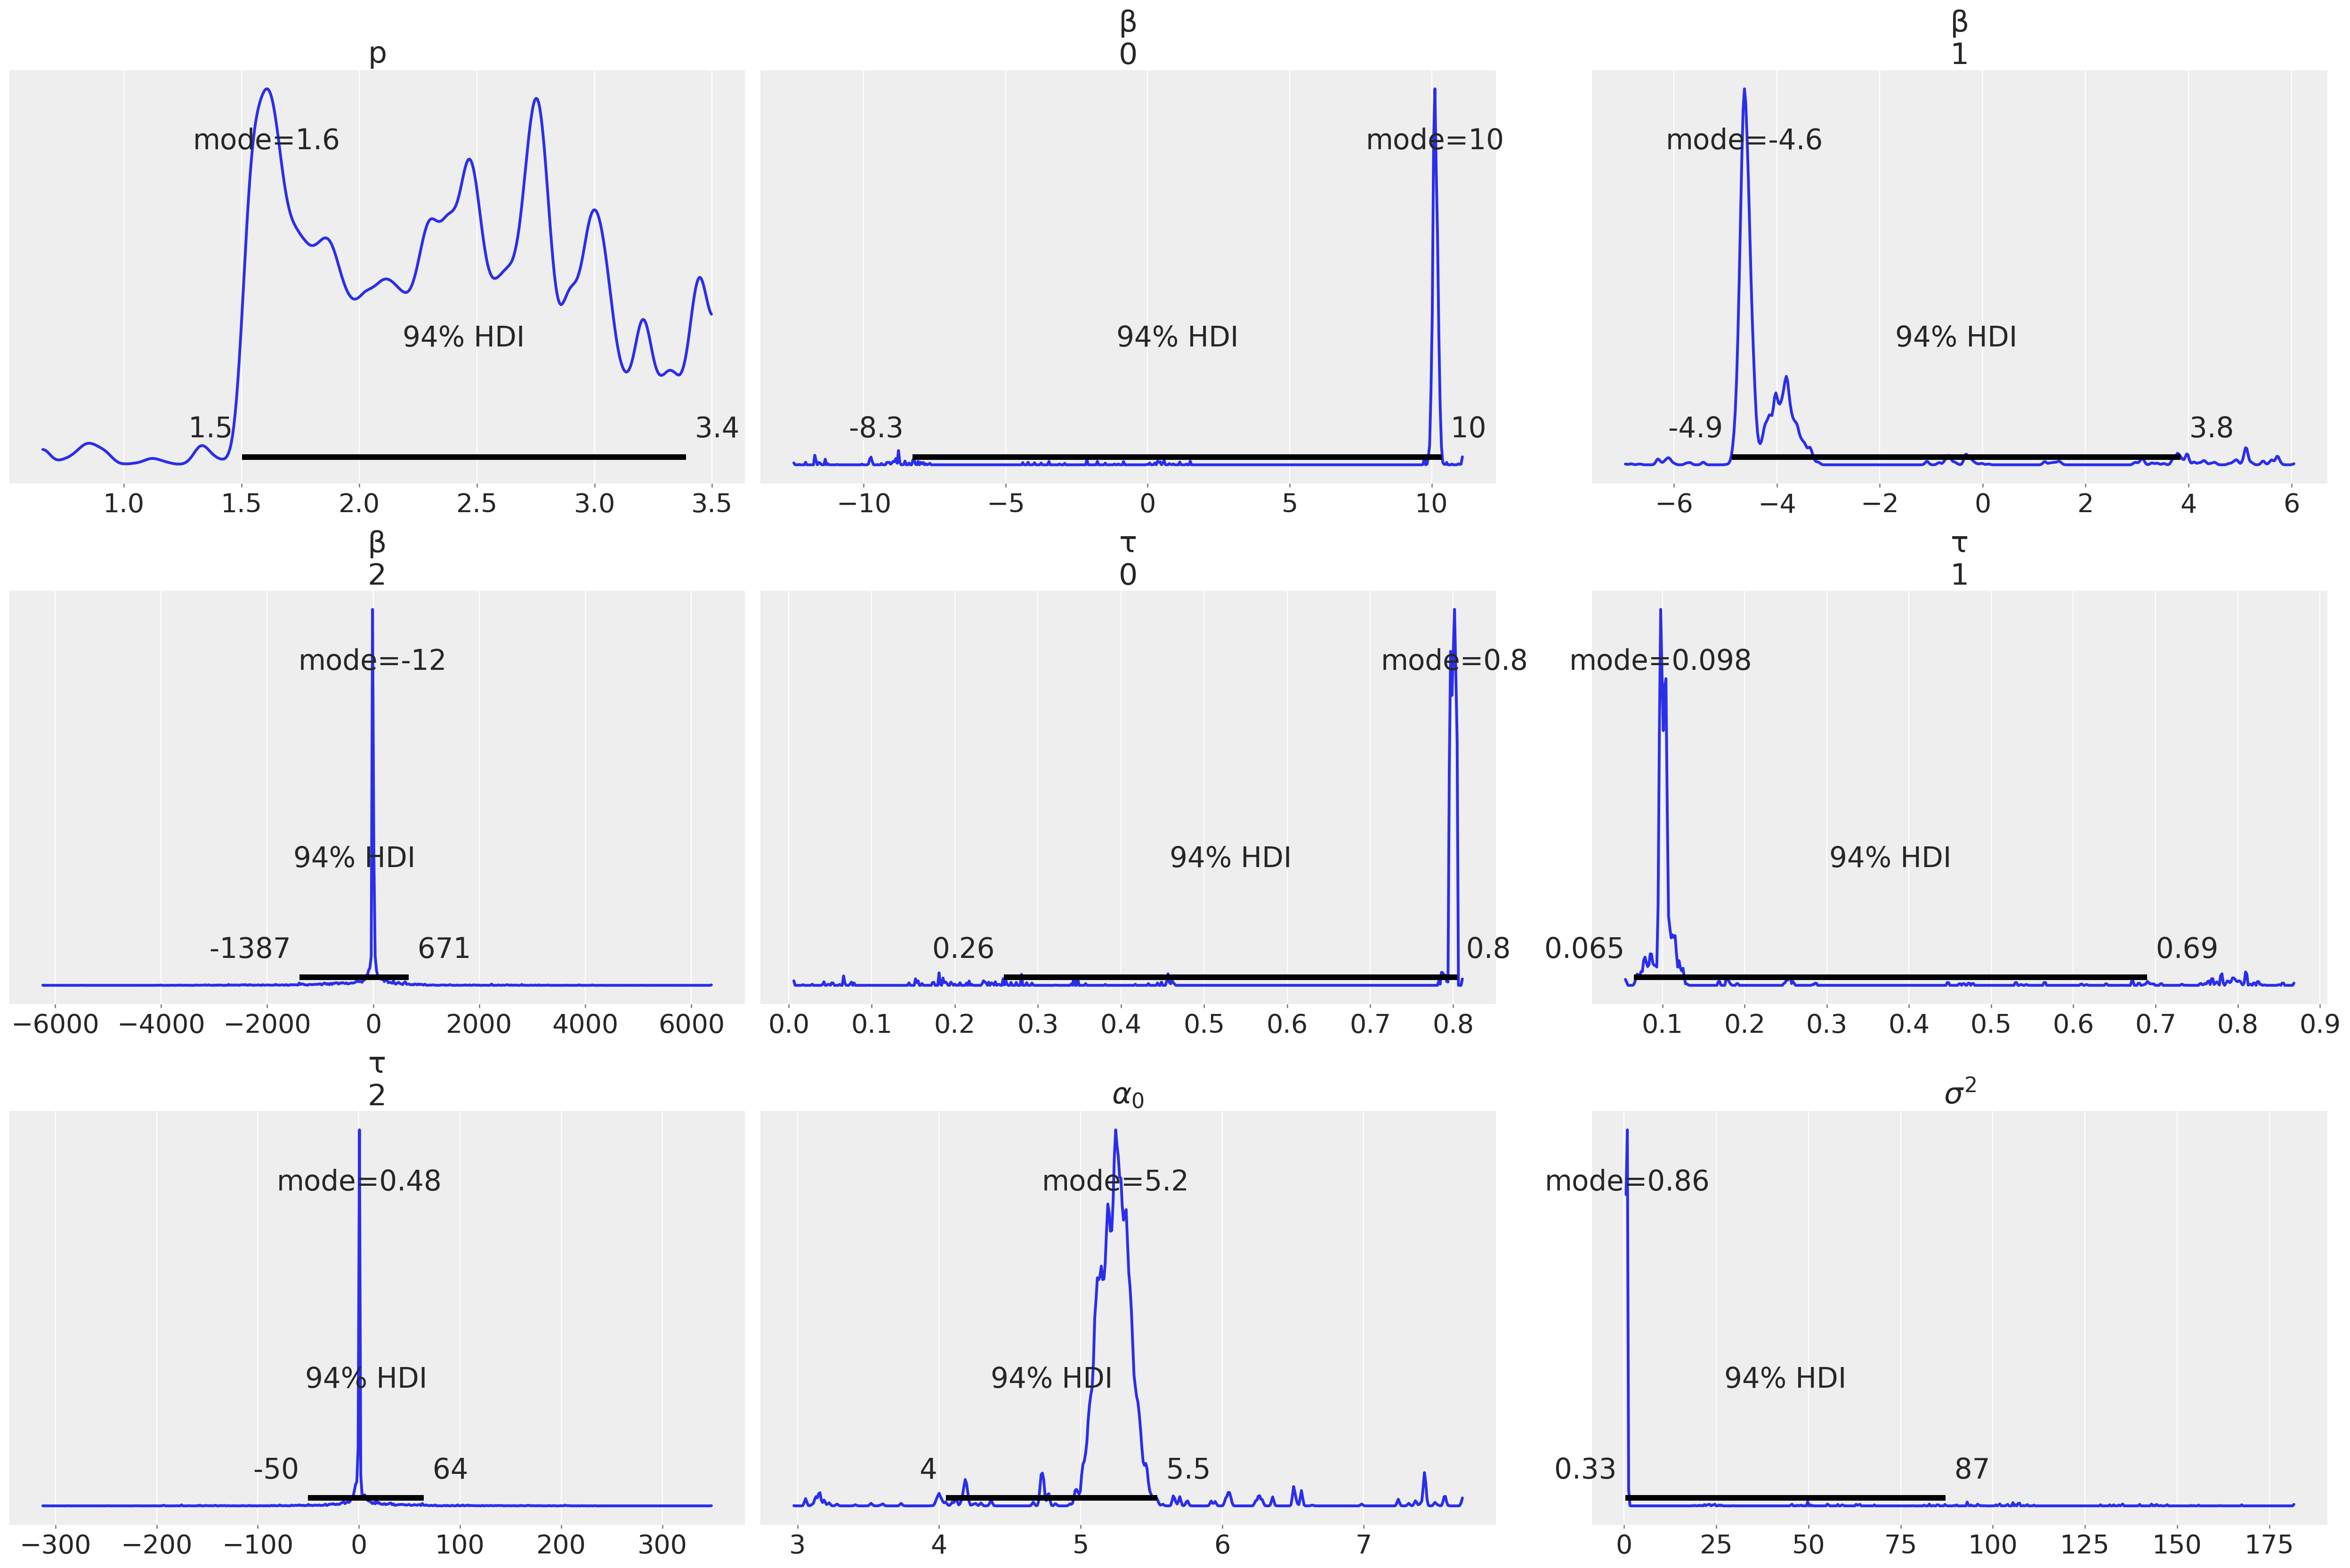

In [21]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

bpv [T=min]: 0.134
bpv [T=max]: 0.661
bpv [T=median]: 0.759
bpv [T=mean]: 0.569
bpv [T=std]: 0.671


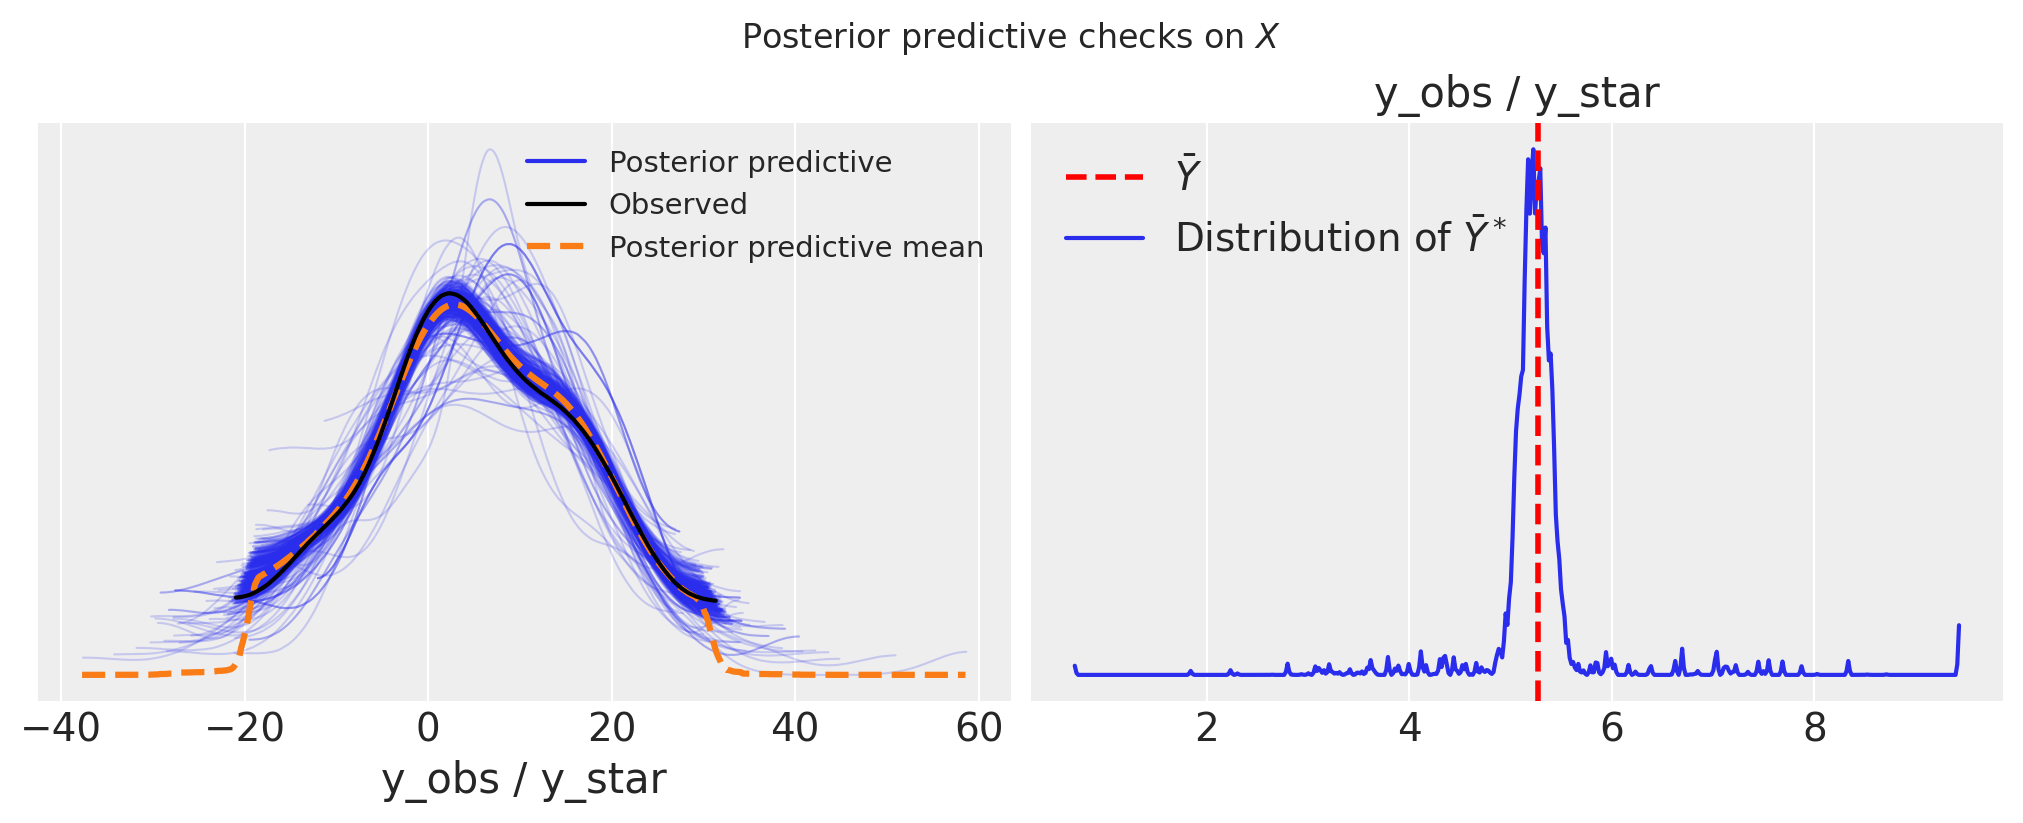

In [22]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = generate_pp(idata_emcee, X, theta_names, rng=rng)
    utils.pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

utils.plot_ppc(idata_emcee, n_samples=500, ax=axs[0],
               data_pairs={'y_obs': 'y_star'})

az.plot_bpv(idata_emcee, kind='t_stat', t_stat='mean',
            ax=axs[1], plot_mean=False,
            data_pairs={'y_obs': 'y_star'}, bpv=False)
axs[1].axvline(Y.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


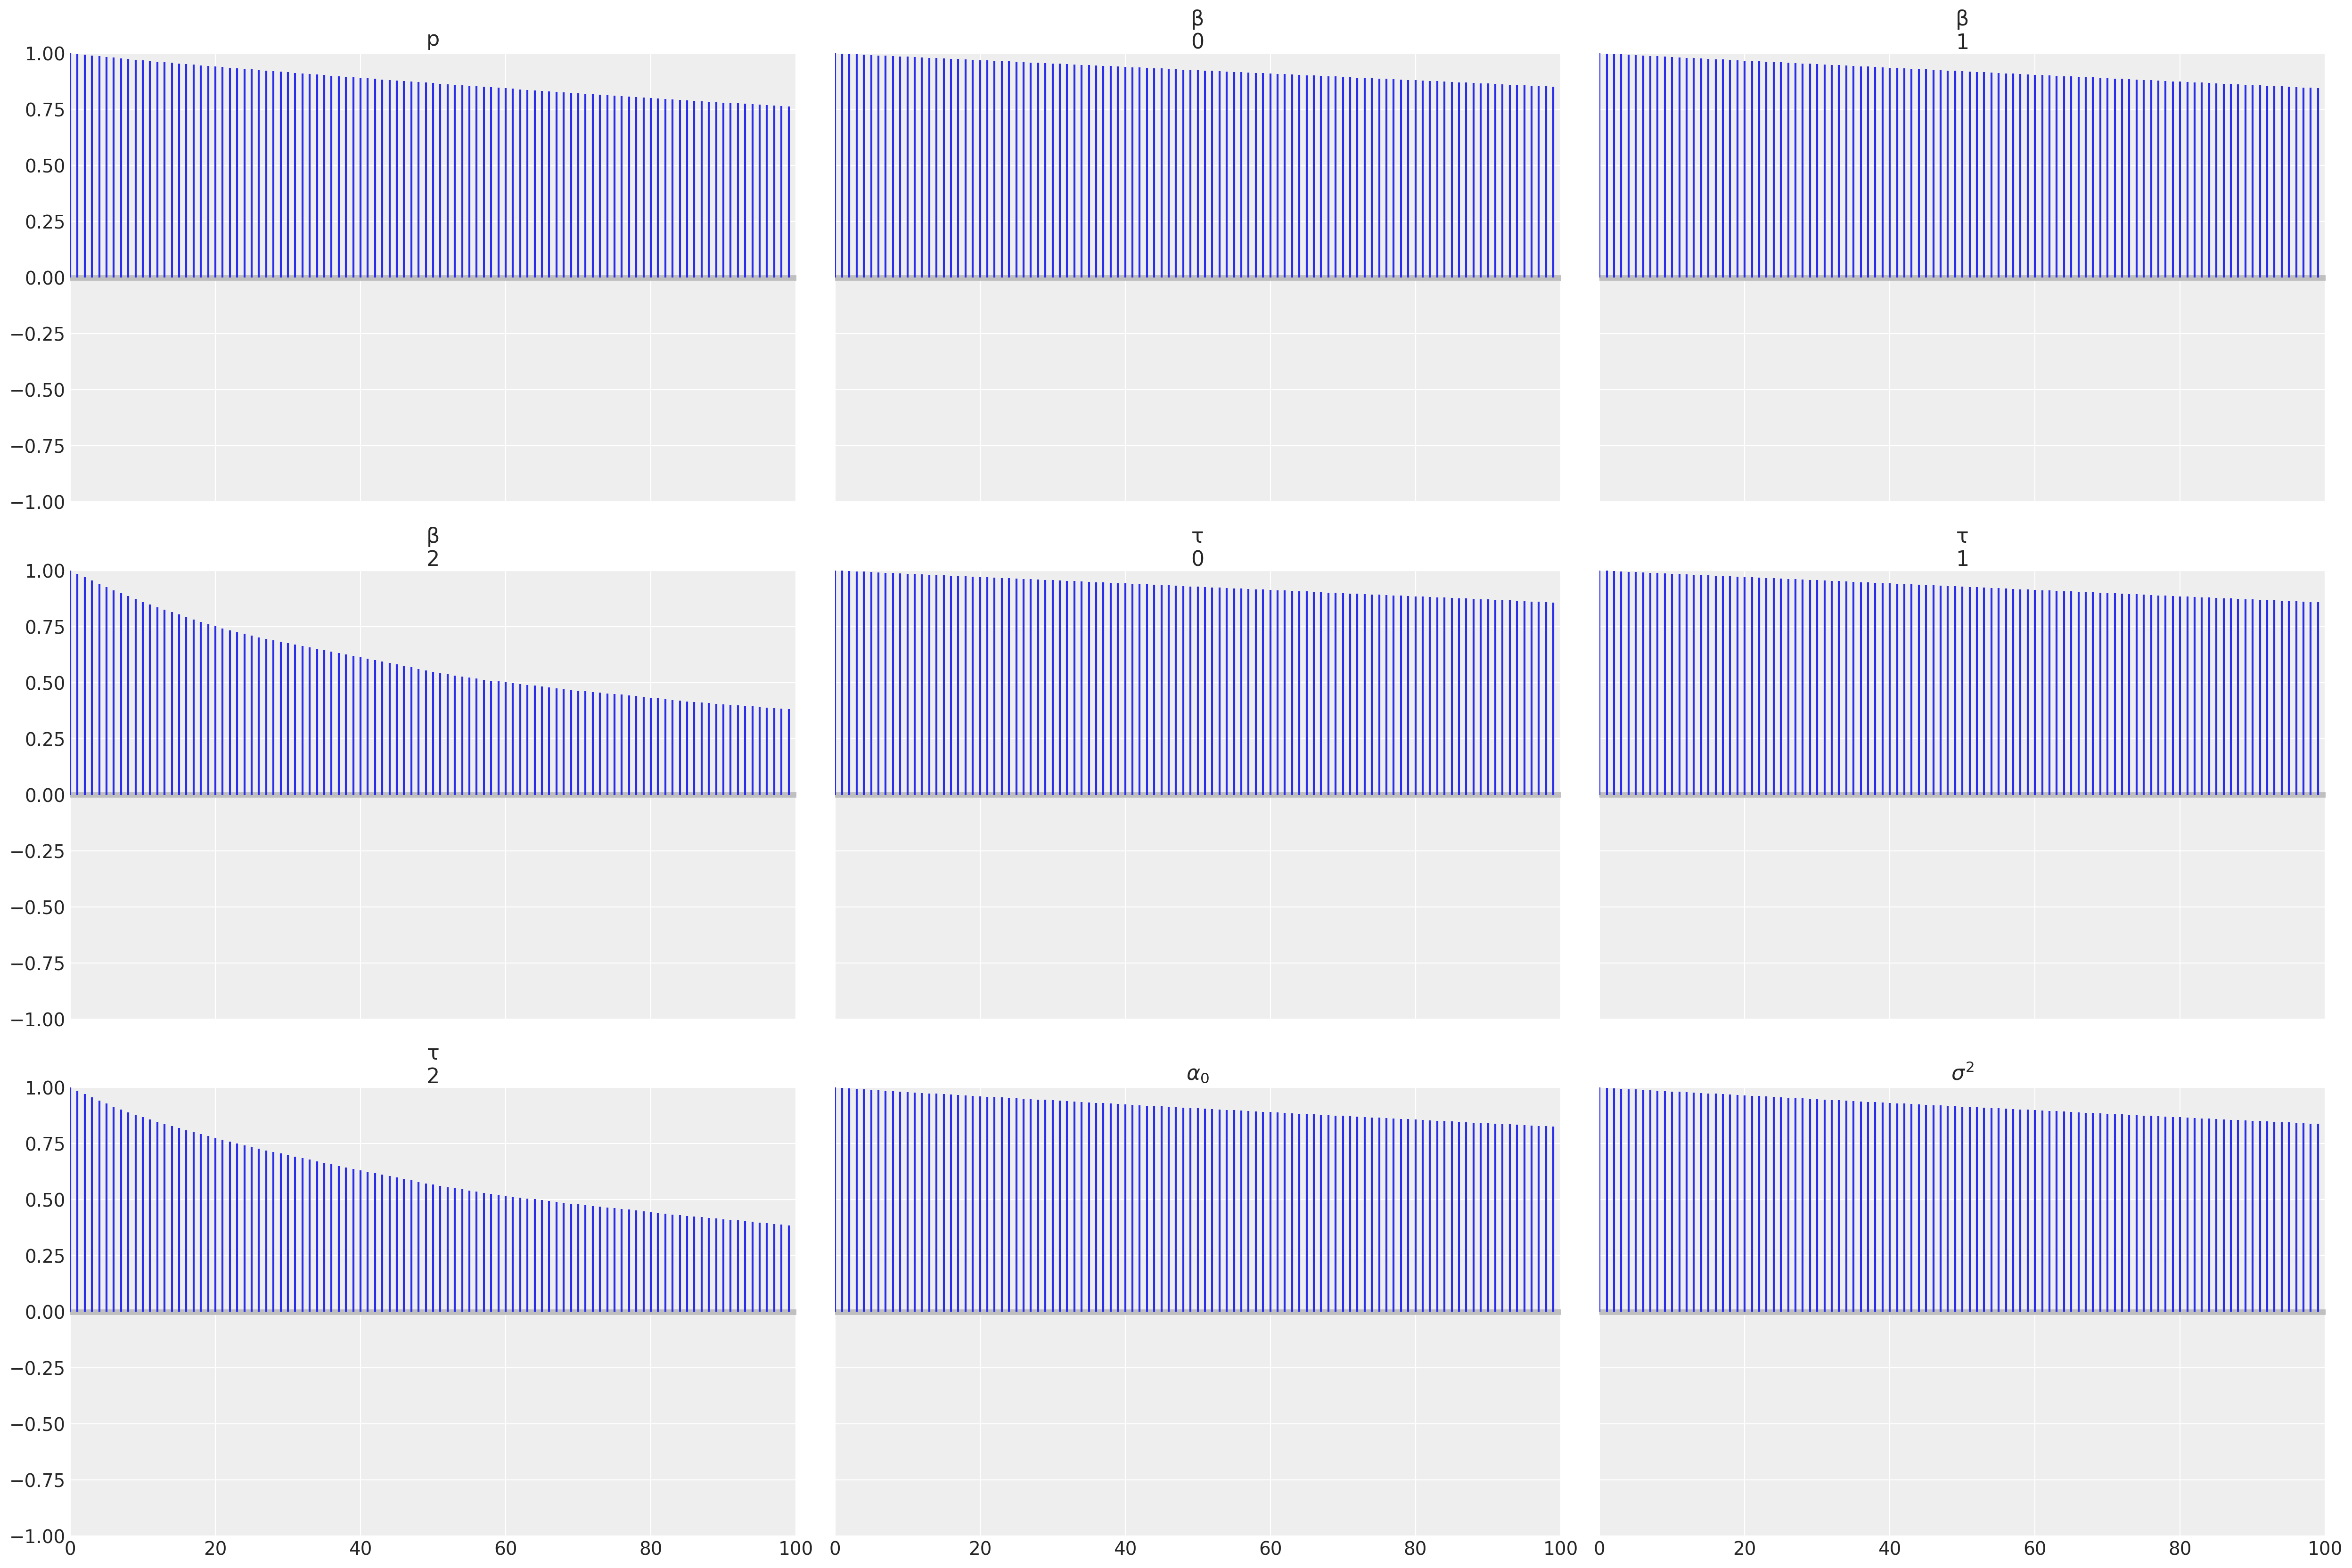

In [23]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

bpv [T=min]: 0.519
bpv [T=max]: 0.747
bpv [T=median]: 0.448
bpv [T=mean]: 0.578
bpv [T=std]: 0.789


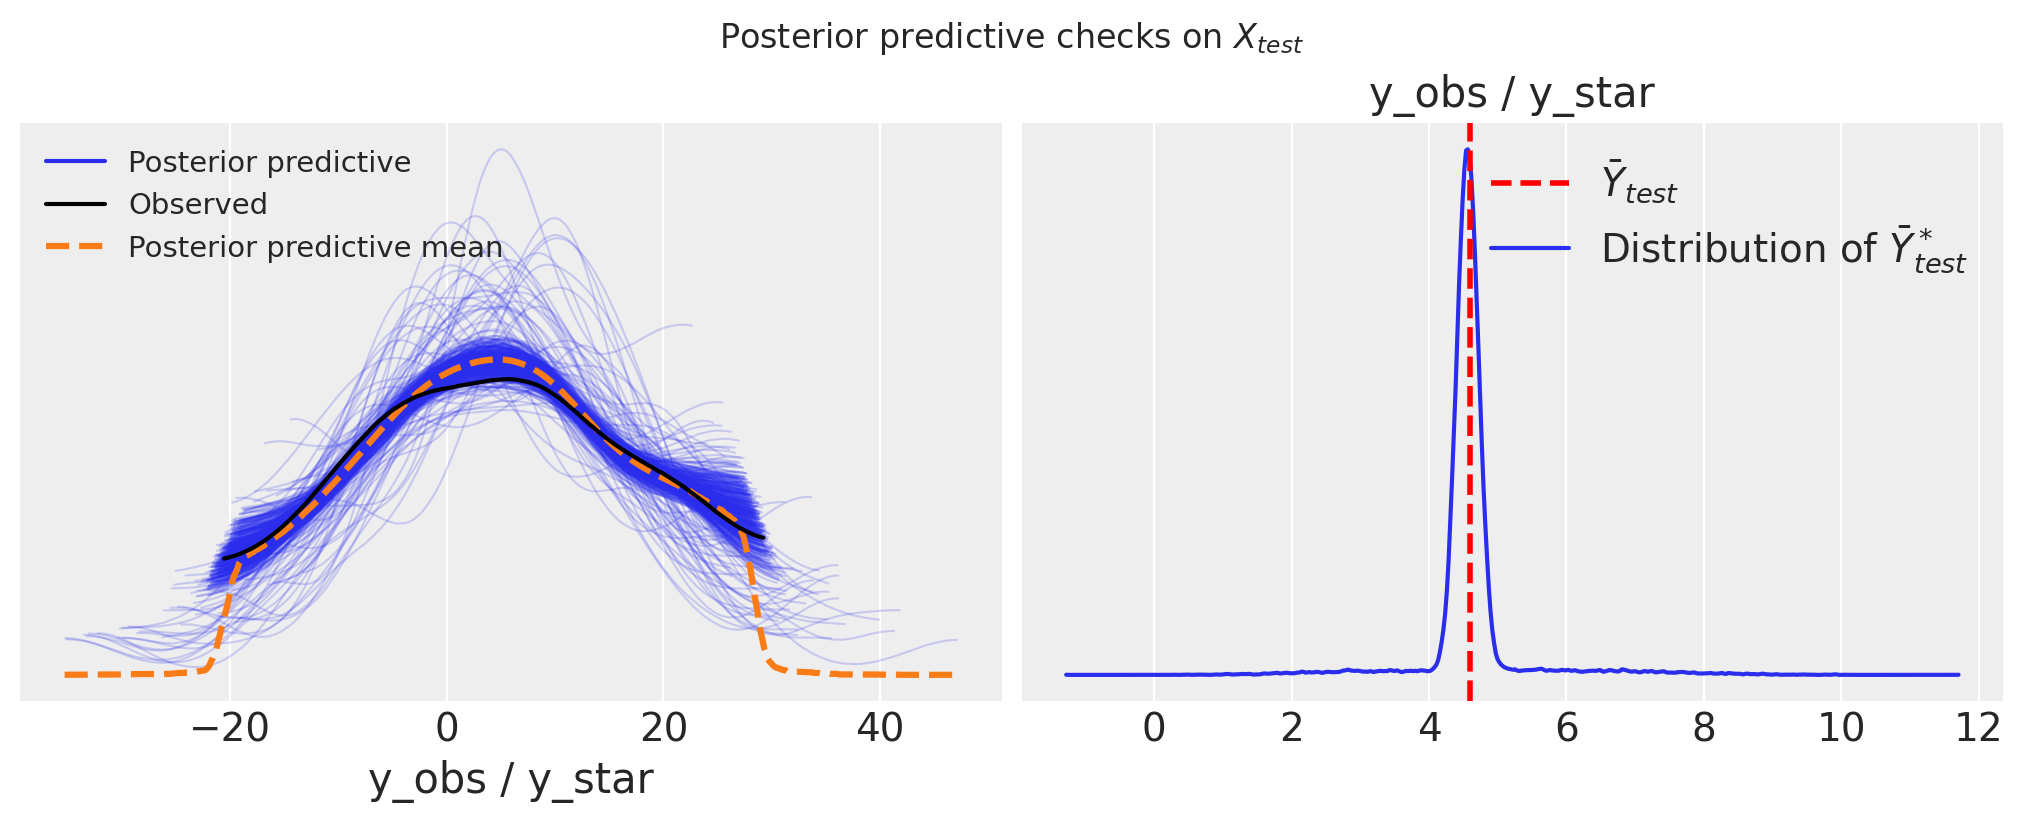

In [24]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = generate_pp(idata_emcee, X_test, theta_names, rng=rng)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

utils.plot_ppc(idata_pp_test, n_samples=500, data_pairs={
               'y_obs': 'y_star'}, ax=axs[0])

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean', data_pairs={
            'y_obs': 'y_star'}, plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y_test.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*_{test}$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [25]:
# -- Compute metrics using several point estimates

df_metrics_emcee = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
metrics_pp = utils.regression_metrics(Y_test, Y_hat_pp)
df_metrics_emcee.loc[0] = [
    "emcee_posterior_mean",
    p_hat,
    metrics_pp["mse"],
    metrics_pp["rmse"],
    metrics_pp["r2"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = point_predict(
        X_test, idata_emcee,
        theta_names, pe)
    metrics_pe = utils.regression_metrics(Y_test, Y_hat_pe)
    df_metrics_emcee.loc[i + 1] = [
        "emcee_" + pe,
        p_hat,
        metrics_pe["mse"],
        metrics_pe["rmse"],
        metrics_pe["r2"]
    ]

df_metrics_emcee.sort_values(results_columns[-2], inplace=True)
df_metrics_emcee.style.hide_index()

In [26]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_emcee, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="emcee",
        point_est=pe)

    df_metrics_emcee_var_sel = df_metrics_emcee_var_sel.append(df_var_sel)

df_metrics_emcee_var_sel.sort_values(results_columns[-2], inplace=True)
df_metrics_emcee_var_sel.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [14]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [167]:
# -- Probabilistic model

def make_model(theta_space, g, eta, X, Y, names, 
               names_aux, mle_theta=None, target_accept=None):
    n, N = X.shape
    grid = theta_space.grid
    p_max = theta_space.p
    prior_p_integers = [int(10*pp) for pp in prior_p.values()]

    if mle_theta is not None:
        b0_array = mle_theta[:p_max]
    else:
        b0_array = g*rng.standard_normal(size=p_max)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)
        b0 = theano.shared(b0_array)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        p_cat = pm.Categorical('p_cat', p=prior_p_integers)
        p = pm.Deterministic(names[0], p_cat + 1)
        tau = pm.Uniform(names[2], 0.0, 1.0, shape=(p_max,))
        tau_red = tau[:p]
        idx = np.abs(grid - tau_red[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        I = tt.eye(p)
        G_tau_reg = G_tau + eta*tt.max(tt.nlinalg.eigh(G_tau)[0])*I
        G_log_det = pm.math.logdet(G_tau_reg)
        
        def beta_lprior(x):
            b = (x - b0)[:p]

            return (0.5*G_log_det
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[1], beta_lprior, shape=(p_max,))
        beta_red = beta[:p]

        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta_red)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)
        
        # Set sampling method
        
        step1 = pm.CategoricalGibbsMetropolis([p])
        
        if USE_NUTS:
            step2 = pm.NUTS(
                [beta, tau, alpha0, sigma2], 
                target_accept=target_accept)
        else:
            step2 = pm.Metropolis([beta, tau, alpha0, sigma2])
            
        step = [step1, step2]

    return model, step

### Experiments

In [168]:
# -- Hyperparameters

burn = 0
thin = 1
thin_pp = 5

n_samples_nuts = 1000
tune_nuts = 1000
target_accept = 0.8
n_samples_metropolis = 10000
tune_metropolis = 5000

USE_NUTS = False

In [169]:
# -- Run sampler

model, step = make_model(theta_space, g, eta, X, Y, theta_names,
                   theta_names_aux[:1], mle_theta_tr, target_accept)

with model:
    if USE_NUTS:
        idata_pymc = pm.sample(n_samples_nuts, cores=2,
                               tune=tune_nuts, step=step,
                               return_inferencedata=True)
    else:
        idata_pymc = pm.sample(n_samples_metropolis, cores=2,
                               tune=tune_metropolis, step=step,
                               return_inferencedata=True)

    idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [p_cat]
>CompoundStep
>>Metropolis: [α0 and log σ]
>>Metropolis: [τ]
>>Metropolis: [β]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [170]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p            2.410  0.492   2.000    3.000      0.311    0.252       3.0   
β[0]        10.138  0.071  10.013   10.275      0.001    0.001    2796.0   
β[1]        -4.145  0.608  -4.793   -3.169      0.375    0.303       4.0   
β[2]        -4.962  5.243 -16.962   -0.374      3.425    2.810       3.0   
τ[0]         0.800  0.003   0.796    0.805      0.000    0.000    2551.0   
τ[1]         0.099  0.009   0.078    0.115      0.001    0.001      52.0   
τ[2]         0.359  0.247   0.056    0.764      0.158    0.128       3.0   
$\alpha_0$   5.270  0.081   5.120    5.424      0.002    0.001    2451.0   
$\sigma^2$   0.631  0.187   0.330    0.918      0.104    0.082       4.0   

            ess_tail  r_hat    mode  median  
p                3.0   2.30   2.000   2.000  
β[0]          3503.0   1.01  10.153  10.138  
β[1]           110.0   1.51  -4.632  -4.543  
β[2]            11.0   1.93  -1.478  -1.807  
τ[0]          2368.0   1.00   0.805   0.800  
τ[1]            36.0   1.26   0.102   0.100  
τ[2]            43.0   1.80   0.116   0.320  
$\alpha_0$    2605.0   1.01   5.293   5.271  
$\sigma^2$      61.0   1.48   0.423   0.654

Density and trace plot:


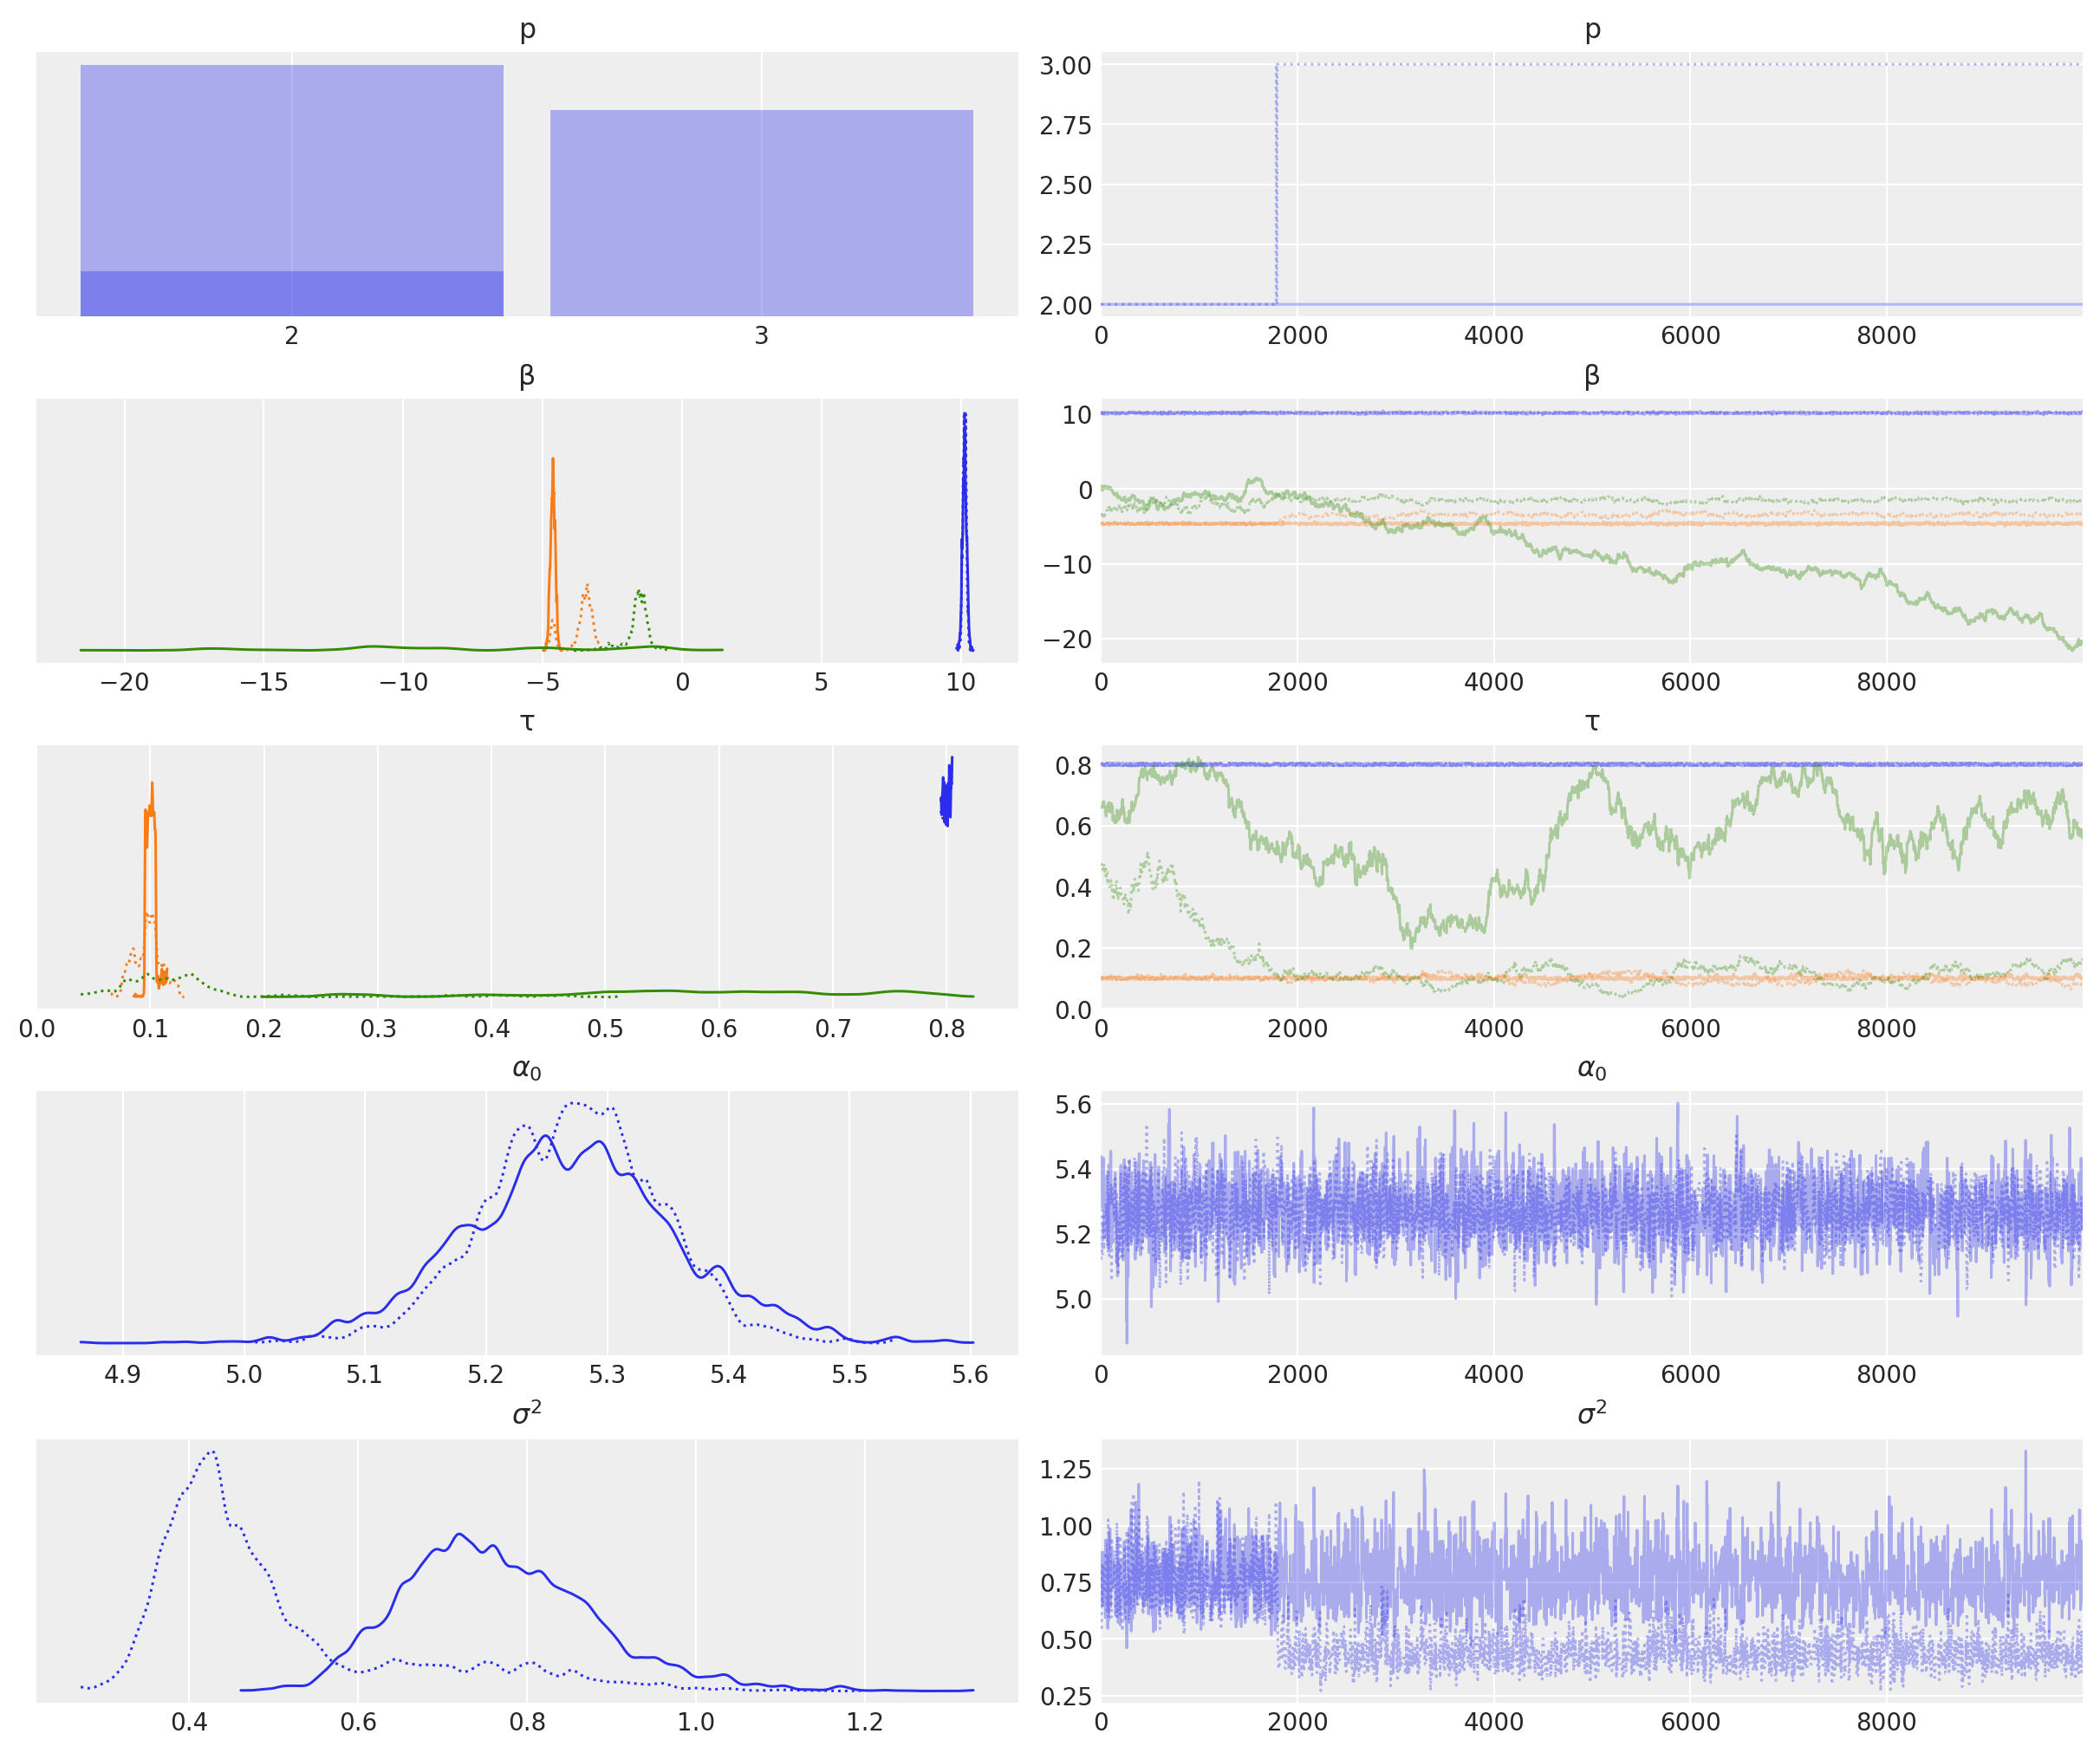

In [171]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


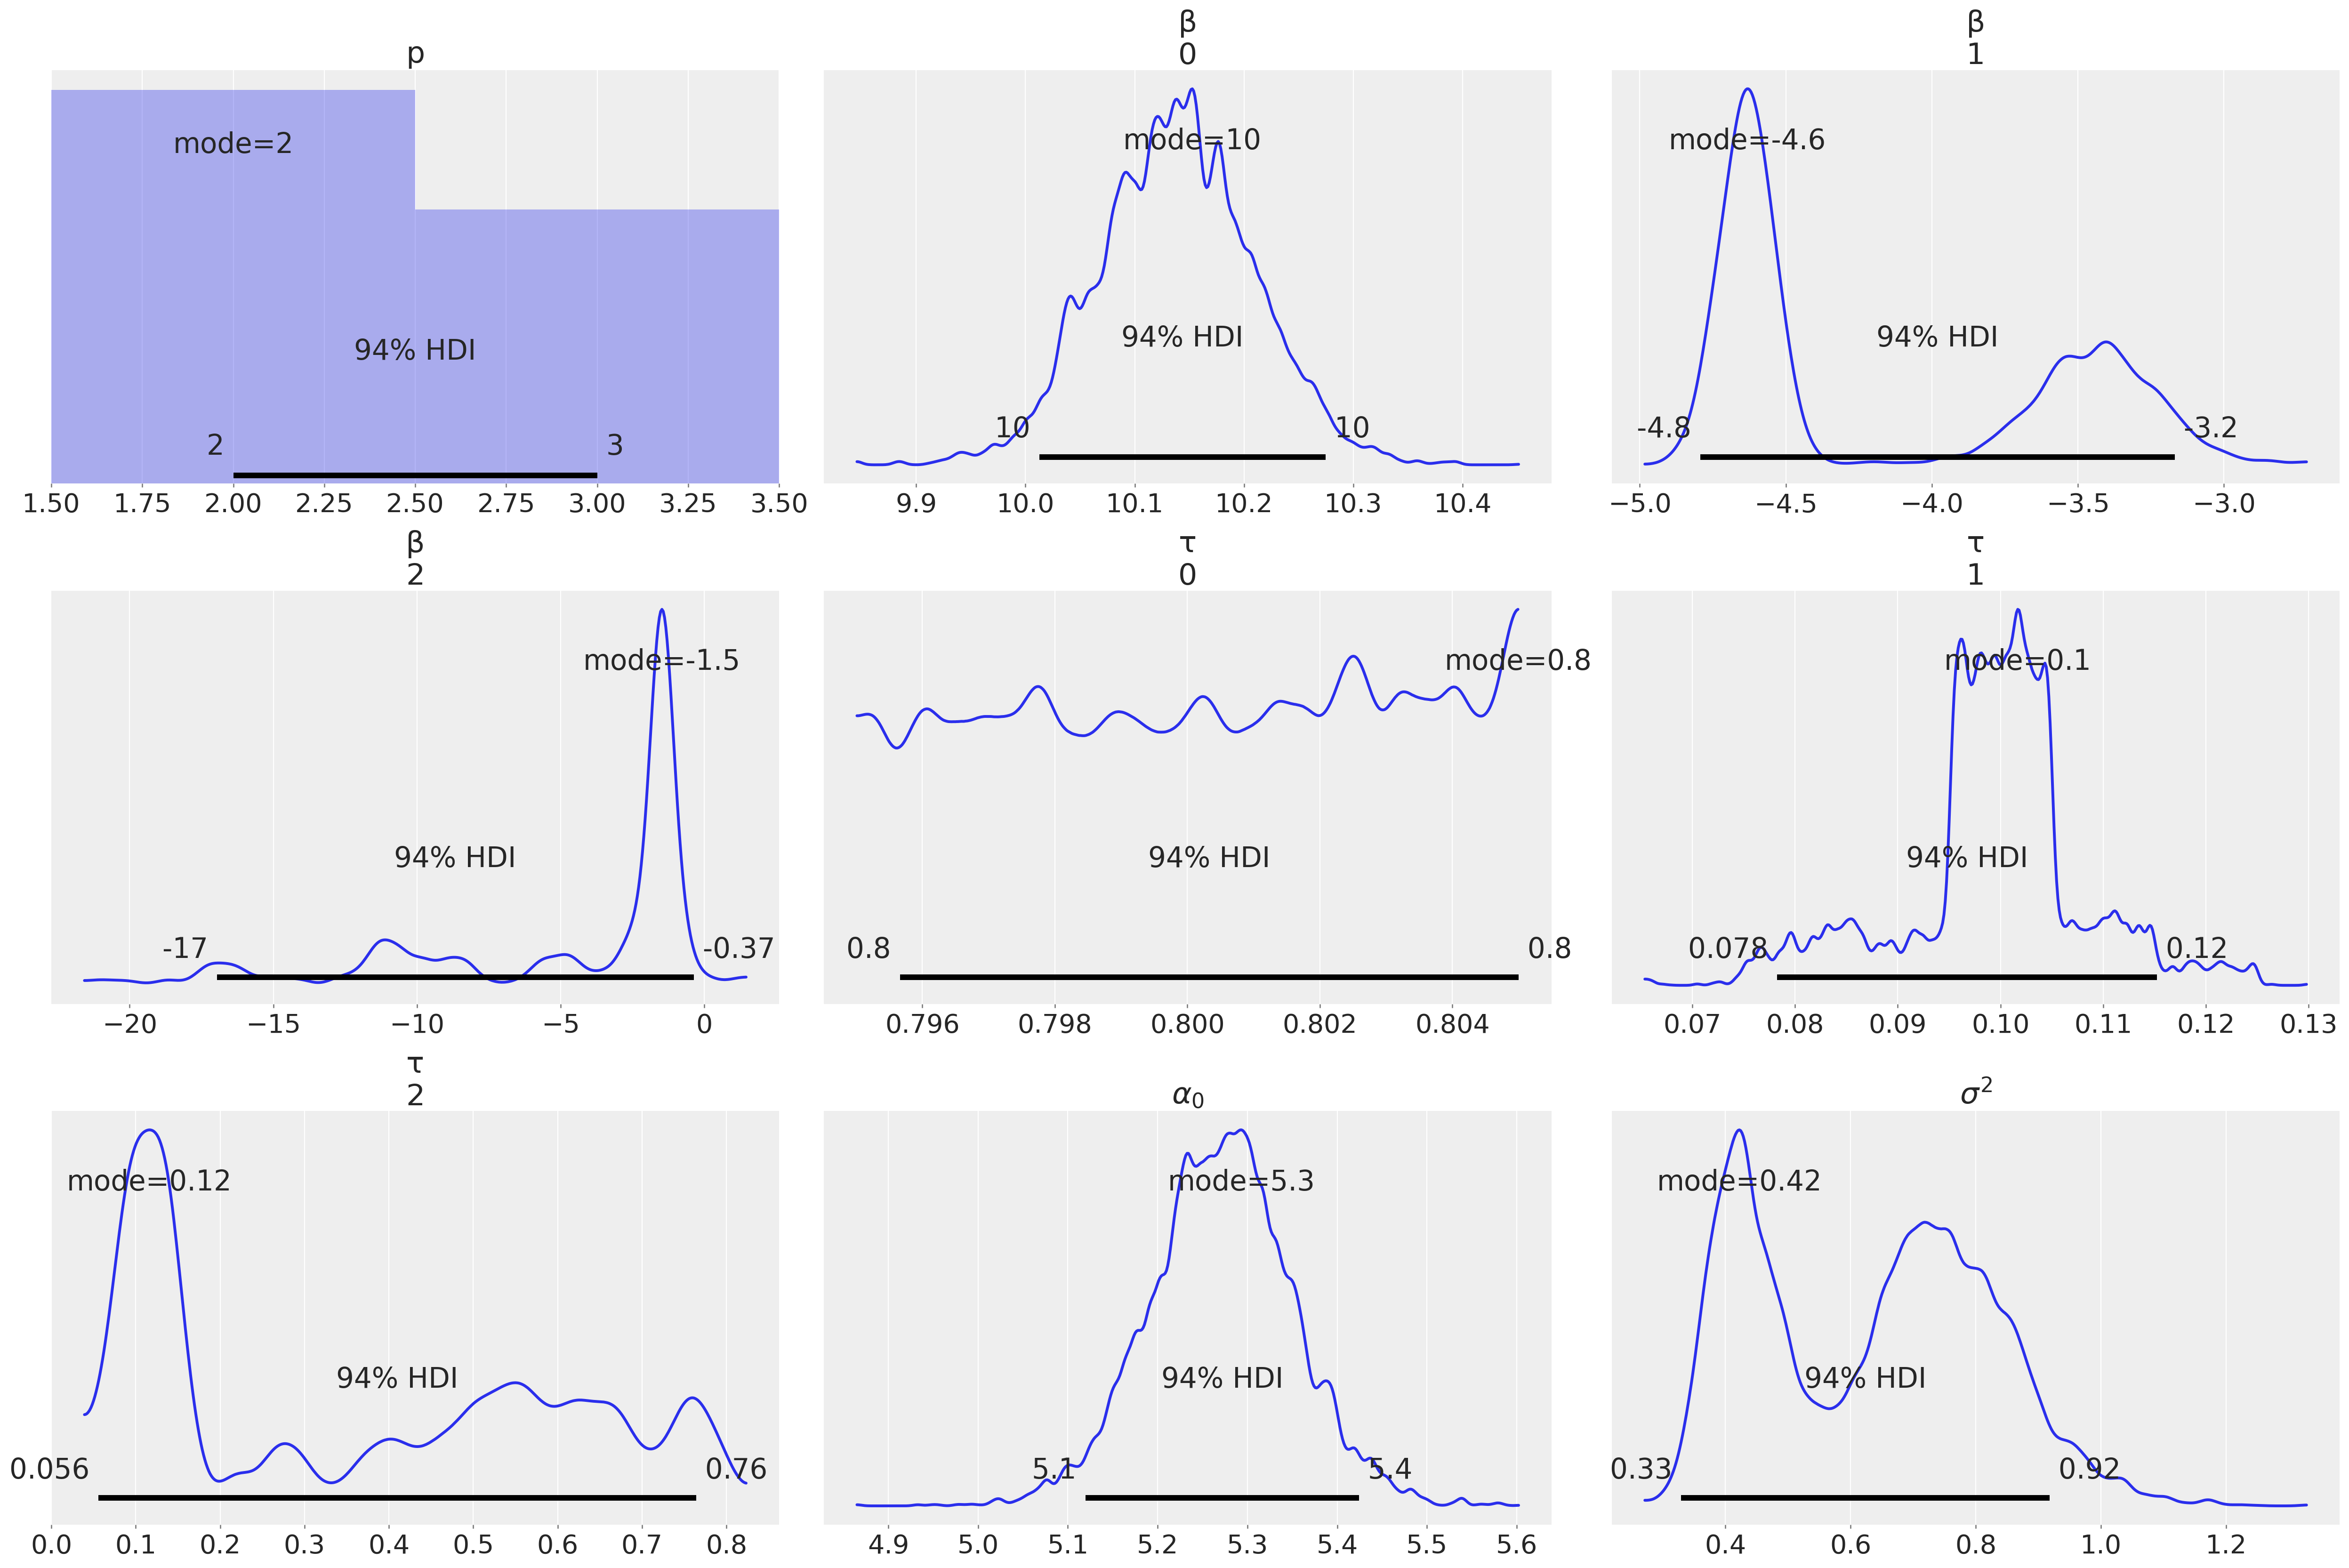

In [172]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 0.053
bpv [T=max]: 0.681
bpv [T=median]: 0.791
bpv [T=mean]: 0.505
bpv [T=std]: 0.659


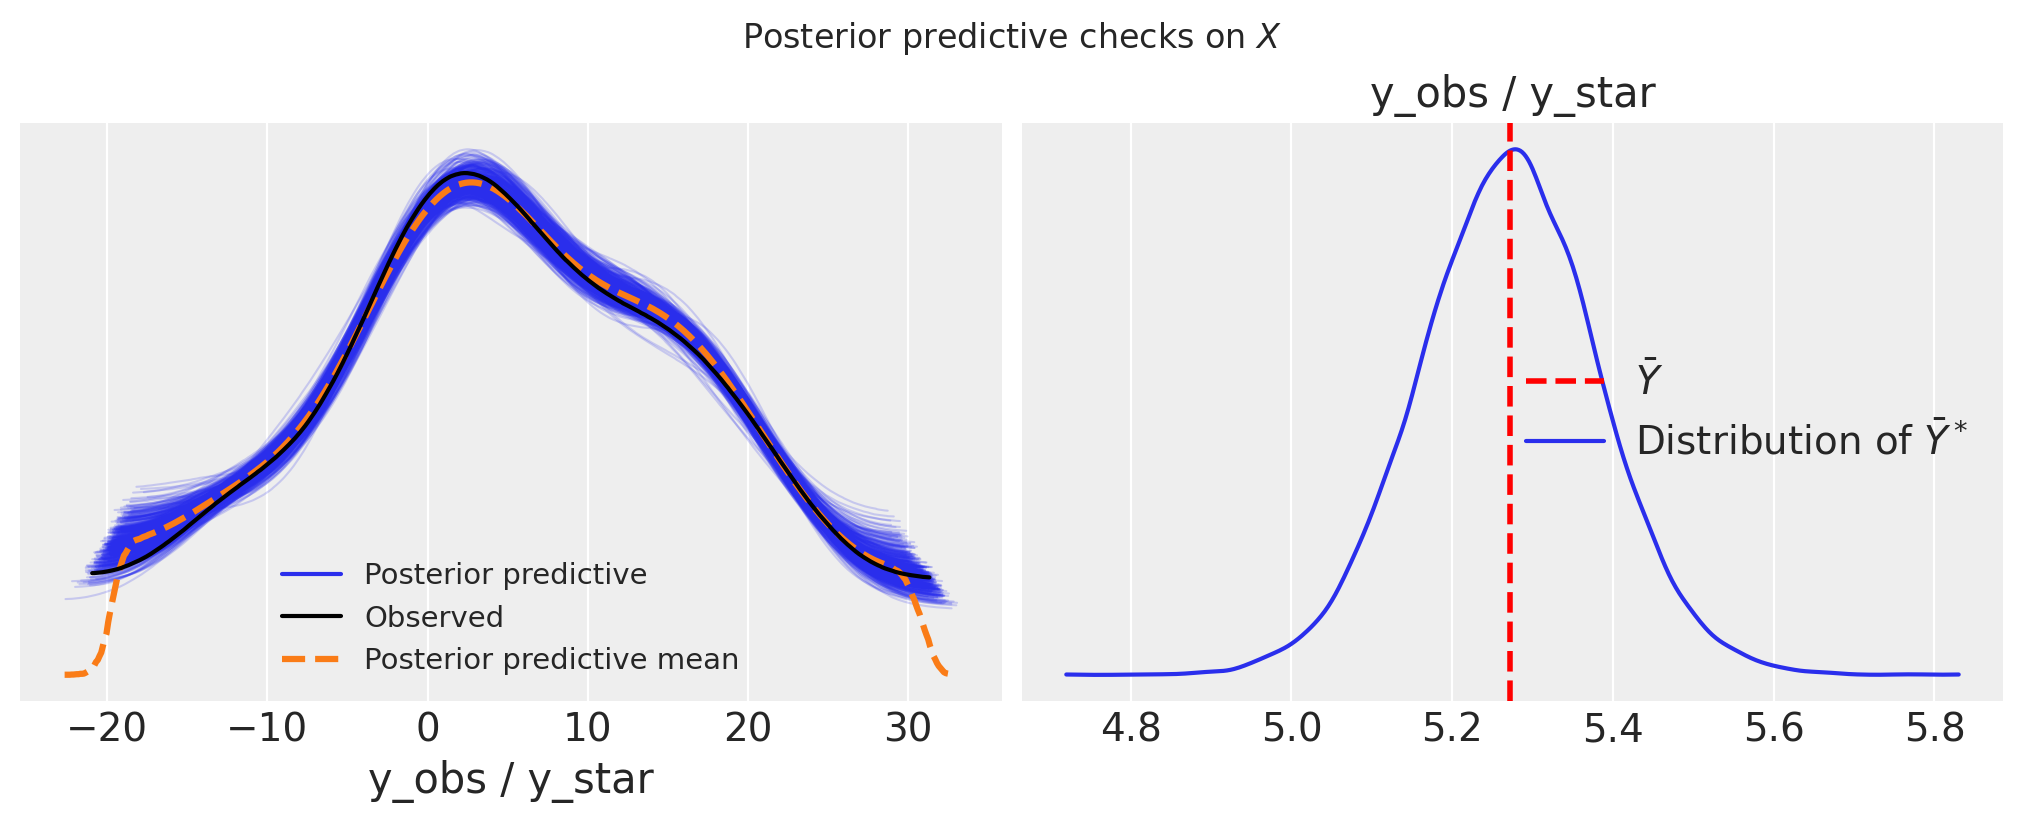

In [173]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    pp = generate_pp(idata_pymc, X, theta_names, rng=rng)
    utils.pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

utils.plot_ppc(idata_pymc, n_samples=500,
               ax=axs[0], data_pairs={"y_obs": "y_star"})

az.plot_bpv(idata_pymc, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1],
            bpv=False, data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


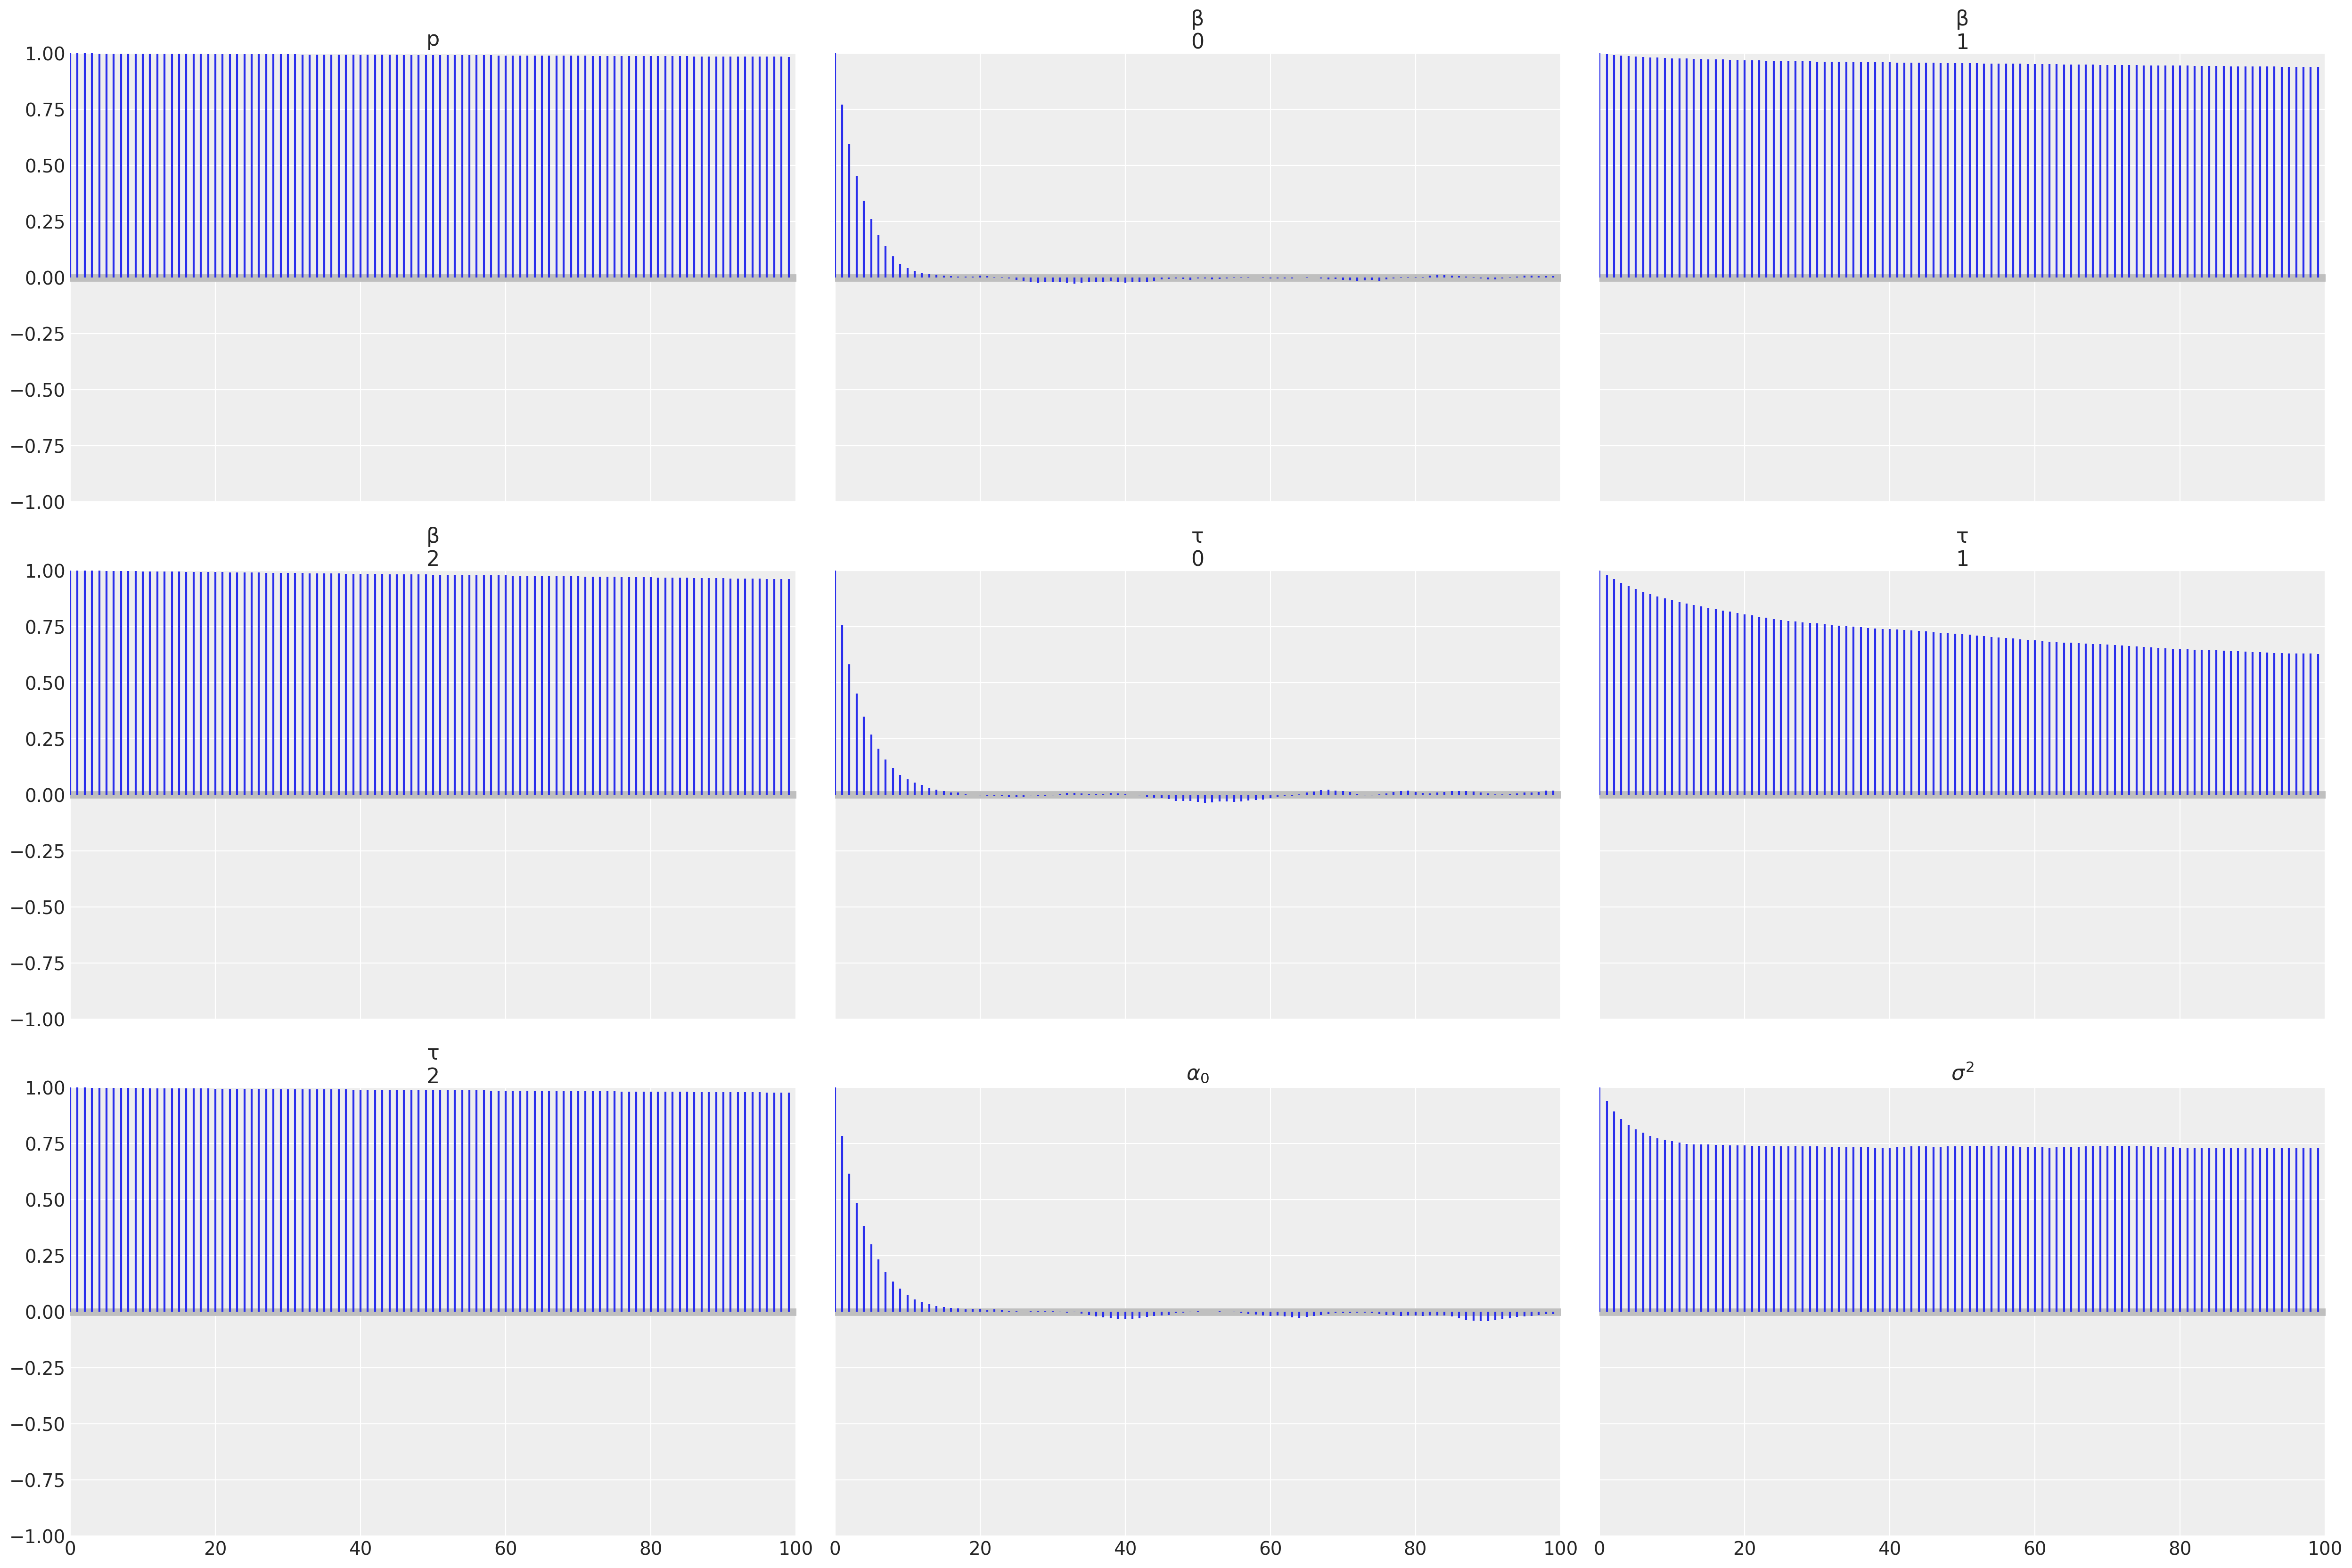

In [174]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

Graphical model:


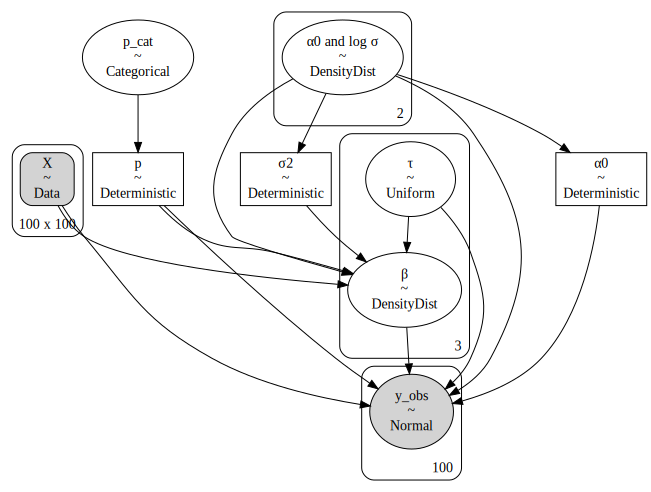

In [175]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 0.518
bpv [T=max]: 0.777
bpv [T=median]: 0.458
bpv [T=mean]: 0.532
bpv [T=std]: 0.795


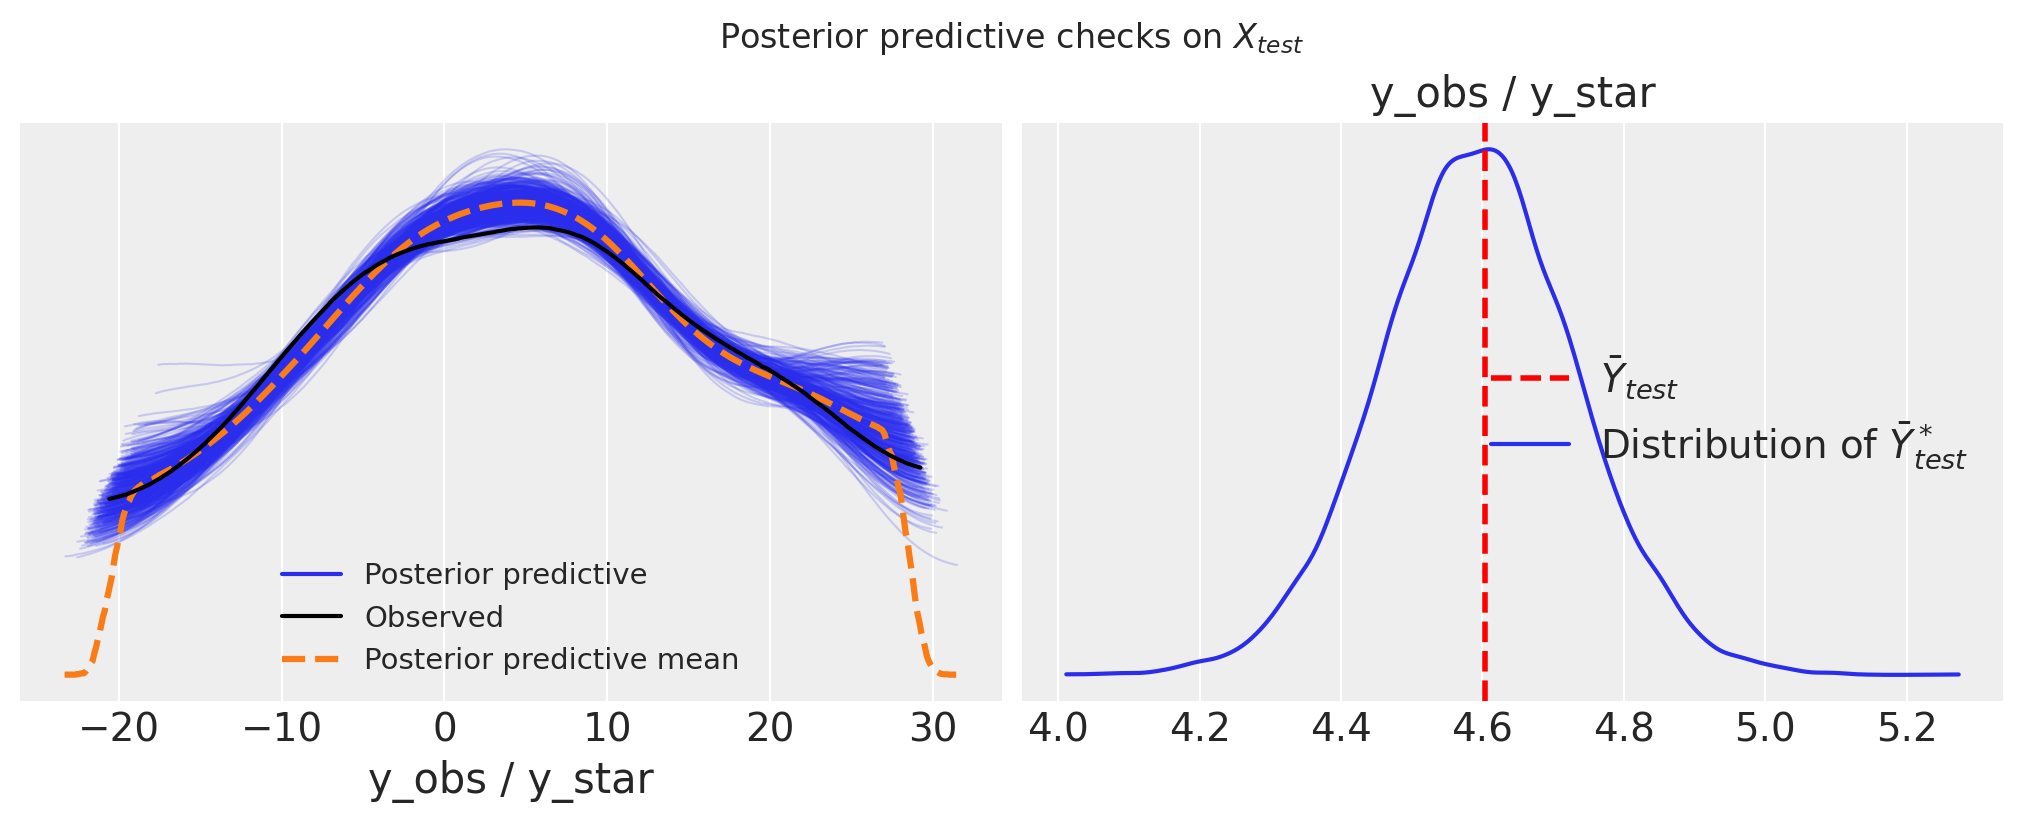

In [176]:
# -- Generate and plot posterior predictive samples from X_test

model_test, _ = make_model(theta_space, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta_tr, target_accept)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    pp_test = generate_pp(idata_pymc, X_test, theta_names, rng=rng)
    idata_pp_test = utils.pp_to_idata(
        [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

utils.plot_ppc(idata_pp_test, n_samples=500,
               ax=axs[0], data_pairs={"y_obs": "y_star"})

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1],
            bpv=False, data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y_test.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [177]:
# -- Compute metrics using several point estimates

df_metrics_pymc = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
metrics_pp = utils.regression_metrics(Y_test, Y_hat_pp)
df_metrics_pymc.loc[0] = [
    "pymc_posterior_mean",
    p_hat,
    metrics_pp["mse"],
    metrics_pp["rmse"],
    metrics_pp["r2"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = point_predict(
        X_test, idata_pymc,
        theta_names, pe)
    metrics_pe = utils.regression_metrics(Y_test, Y_hat_pe)
    df_metrics_pymc.loc[i + 1] = [
        "pymc_" + pe,
        p_hat,
        metrics_pe["mse"],
        metrics_pe["rmse"],
        metrics_pe["r2"]
    ]

df_metrics_pymc.sort_values(results_columns[-2], inplace=True)
df_metrics_pymc.style.hide_index()

In [178]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_pymc, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="pymc",
        point_est=pe)

    df_metrics_pymc_var_sel = df_metrics_pymc_var_sel.append(df_var_sel)

df_metrics_pymc_var_sel.sort_values(
    results_columns[-2], inplace=True)
df_metrics_pymc_var_sel.style.hide_index()

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [41]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Mar 10 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.30.1

autopep8  : 1.6.0
pymc3     : 3.11.4
numpy     : 1.20.3
logging   : 0.5.1.2
sys       : 3.9.10 (main, Mar  8 2022, 08:52:33) 
[GCC 11.2.0]
json      : 2.0.9
matplotlib: 3.5.1
arviz     : 0.11.4
scipy     : 1.7.3
emcee     : 3.1.1
pandas    : 1.3.5
theano    : 1.1.2
skfda     : 0.0

Watermark: 2.2.0

